4. 機械学習の手法

4.1. データセット

In [5]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error, roc_auc_score, r2_score

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.neural_network import MLPRegressor
import itertools
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D

df = pd.read_excel('/mnt/c/CEA/all_mixtureexp15.xlsx')

l1=['Fuel','Diluent','Equivalentratio','CoefficientDiluent','Oxidizer','diluentratio','P0','H0[KJ/kg]', 'M0[kg/kmol]', 'γ0[-]', 'a0[m/s]',\
        'pcj[bar]', 'Tcj[K]', 'Hcj[KJ/kg]',\
                    'Mcj[kg/kmol]', 'γcj[-]', 'acj[m/s]',\
                         'Mcj[-]', 'Vcj[m/s]',\
        'Pvn[bar]', 'Tvn[K]', 'Hvn[KJ/kg]',\
                      'γvn[-]','avn[m/s]','theta','inductionlength','Lr','Lc']

XpcaFLRDED = pd.DataFrame({'P0':df['P0']})

for i in range(len(l1)):
    XpcaFLRDED[l1[i]]=df[l1[i]]
print(len(XpcaFLRDED))

XpcaFLRDED = XpcaFLRDED[~( XpcaFLRDED['theta'] == 0)]

print(len(XpcaFLRDED))

XpcaFLRDED = XpcaFLRDED[~( XpcaFLRDED['inductionlength'] == 0)]

print(len(XpcaFLRDED))

#XpcaFLRDED =  XpcaFLRDED[~( XpcaFLRDED['Fuel'] == 'C2H2') | ~( XpcaFLRDED['Diluent'] == 'Ar') | ~( XpcaFLRDED['Lc'] ==  5)]
#XpcaFLRDED =  XpcaFLRDED[~( XpcaFLRDED['Fuel'] == 'C2H2') | ~( XpcaFLRDED['Diluent'] == 'Ar') | ~( XpcaFLRDED['Lc'] ==  10)]
XpcaFLRDED =  XpcaFLRDED[~( XpcaFLRDED['Diluent'] == 'Kr')]

dfC2H2Hetrain = XpcaFLRDED[~( XpcaFLRDED['Fuel'] == 'C2H2') | ~( XpcaFLRDED['Diluent'] == 'He')]
dfC2H2Hetest = XpcaFLRDED[( XpcaFLRDED['Fuel'] == 'C2H2') & ( XpcaFLRDED['Diluent'] == 'He')]

dfC3H6O2train = dfC2H2Hetrain[~( dfC2H2Hetrain['Fuel'] == 'C3H6') | ~( dfC2H2Hetrain['Oxidizer'] == 'O2')]
dfC3H6O2test = dfC2H2Hetrain[( dfC2H2Hetrain['Fuel'] == 'C3H6') & ( dfC2H2Hetrain['Oxidizer'] == 'O2')]

dftrainval = dfC3H6O2train.sample(frac=1)

X_trainval = dftrainval.drop(columns=['Diluent','Fuel','Equivalentratio','CoefficientDiluent','Oxidizer','Lr','Lc','diluentratio','inductionlength'])
XC2H2Hetest = dfC2H2Hetest.drop(columns=['Diluent','Fuel','Equivalentratio','CoefficientDiluent','Oxidizer','Lr','Lc','diluentratio','inductionlength'])
XC3H6O2test  = dfC3H6O2test.drop(columns=['Diluent','Fuel','Equivalentratio','CoefficientDiluent','Oxidizer','Lr','Lc','diluentratio','inductionlength'])

y_trainval = dftrainval['Lr']
yC2H2Hetest = dfC2H2Hetest['Lr']
yC3H6O2test = dfC3H6O2test['Lr']


827
729
729


Index(['P0', 'H0[KJ/kg]', 'M0[kg/kmol]', 'γ0[-]', 'pcj[bar]', 'Tcj[K]',
       'Hcj[KJ/kg]', 'Mcj[kg/kmol]', 'γcj[-]', 'Mcj[-]', 'Tvn[K]', 'theta'],
      dtype='object')
12


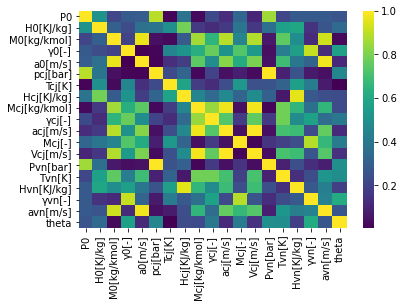

In [6]:

threshold = 0.9

feat_corr = set()
corr_matrix = X_trainval.corr()
corr_matrix.to_excel('/mnt/c/CEA/matrix1.xlsx')
corr_matrix = corr_matrix.abs()
corr_matrix.to_excel('/mnt/c/CEA/matrix2.xlsx')
plt.figure()
sns.heatmap(corr_matrix,cmap='viridis')
#plt.tight_layout()
plt.savefig('gurafu5.png')

for i in range(len(corr_matrix.columns)):
    z=0
    corr_matrix.iloc[i, i]=0
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            feat_name1 = corr_matrix.columns[i]
            feat_name2 = corr_matrix.columns[j]
            corr_matrix.iloc[i, j]=0
            corr_matrix.iloc[j,i]=0
            corr_matrix.iloc[i, z] = feat_name2
            feat_corr.add(feat_name1)
            z=z+1

        else:
            corr_matrix.iloc[i, j]=0
            corr_matrix.iloc[j,i]=0
        
X_trainval.drop(labels=feat_corr, axis='columns', inplace=True)
XC2H2Hetest.drop(labels=feat_corr, axis='columns', inplace=True)
XC3H6O2test.drop(labels=feat_corr, axis='columns', inplace=True)

print(X_trainval.columns)
print(len(X_trainval.columns))

In [7]:
ss = StandardScaler()
sX_trainval = ss.fit_transform(X_trainval)
#sXC2H2Hetest = ss.transform(XC2H2Hetest)
#sXC3H6O2test = ss.transform(XC3H6O2test)

sX_trainval = pd.DataFrame(sX_trainval,columns=X_trainval.columns)

ss = StandardScaler()
sX_train = ss.fit_transform(X_train)
sX_train = pd.DataFrame(sX_train,columns=X_train.columns)

5. ANN回帰

5.1 学習結果

In [8]:
sol = ['adam']
act = ['relu']
hidd = []

for i in [4]:
    for j in [200]:
        b=[j]*i
        b=tuple(b)
        hidd.append(b)

alp=[1e-2]
param_grid = {'solver':sol,'activation':act,'hidden_layer_sizes':hidd,'alpha':alp}
grid1 = GridSearchCV(MLPRegressor(), param_grid ,cv=10, n_jobs=4)
grid1.fit(sX_trainval,y_trainval)

print('Best parameters: {}'.format(grid1.best_params_))
print('Best cross-validation: {}'.format(grid1.best_score_))

Best parameters: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (200, 200, 200, 200), 'solver': 'adam'}
Best cross-validation: 0.9432561297309936


5.1.1 グリッドサーチによるハイパーパラメーターの最適化

param_alpha                   0.01
param_hidden_layer_sizes          
(200, 200, 200, 200)      0.943256


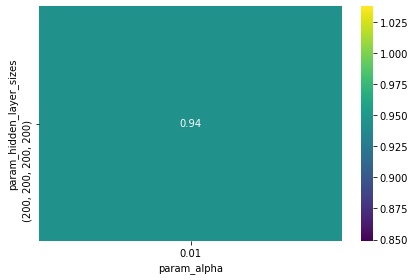

In [9]:
plt.figure()
cv_result = pd.DataFrame(grid1.cv_results_)
cv_result = cv_result[['param_hidden_layer_sizes', 'param_alpha', 'mean_test_score']]
cv_result_pivot = cv_result.pivot_table('mean_test_score', 'param_hidden_layer_sizes', 'param_alpha')
print(cv_result_pivot )
heat_map = sns.heatmap(cv_result_pivot, cmap='viridis', annot=True)
plt.tight_layout()
plt.savefig("gurafu8.png")

5.1.2 学習曲線

5.1.3 重み係数の可視化

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 37325 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 12415 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 34892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 21015 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 12398 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 37325 missing from current font.
  font.set_

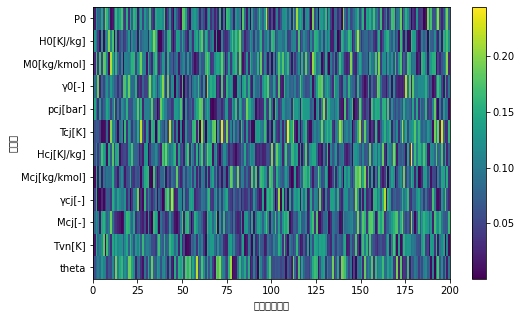

In [10]:
mlp = MLPRegressor(hidden_layer_sizes=(200,200,200,200),alpha=0.01)
mlp.fit(sX_trainval,y_trainval)
plt.figure(figsize=(8, 5))
mlp.coefs_[0] = np.abs(mlp.coefs_[0])
plt.imshow(mlp.coefs_[0], interpolation='none', cmap='viridis',aspect='auto')
plt.yticks(range(12), sX_trainval.columns)
plt.xlim(0,200)
plt.xlabel("重み行列の列")
plt.ylabel("特徴量")
plt.colorbar()
plt.savefig("gurafu9.png")

5.1.4 ANN回帰結果

        P0  Fuel Diluent  Equivalentratio  CoefficientDiluent Oxidizer  \
160  0.502  C2H2      Ar              1.0                 7.0       O2   
96   0.340  C2H2      Ar              1.0                 7.0       O2   
185  0.121  C2H2      Ar              1.0                 7.0       O2   
32   0.380  C2H2      Ar              1.0                 7.0       O2   
4    0.163  C2H2      Ar              1.0                 7.0       O2   
..     ...   ...     ...              ...                 ...      ...   
40   0.400  C2H2      Ar              1.0                 7.0       O2   
15   0.240  C2H2      Ar              1.0                 7.0       O2   
66   1.000  C2H2      Ar              1.0                 7.0       O2   
7    0.180  C2H2      Ar              1.0                 7.0       O2   
1    0.131  C2H2      Ar              1.0                 7.0       O2   

     diluentratio  H0[KJ/kg]  M0[kg/kmol]   γ0[-]  ...  Vcj[m/s]  Pvn[bar]  \
160          50.0     928.23     

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


               MSE        R2  len
H2       10.820737  0.905631  121
C2H2      4.812716  0.971725  123
C2H2AR    6.533524  0.949911  245
C2H2N2    1.194642  0.908388    6
C2H4     12.722423  0.946433   82
C2H4AR   16.466574  0.864593   72
C2H6     11.368109  0.936913   67
C2H6N2O   9.529855  0.788674   13


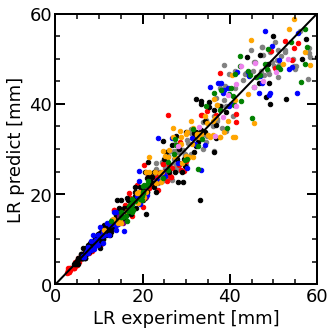

In [11]:
dfH2trainval = dftrainval[ (dftrainval['Fuel'] == 'H2') & (dftrainval['Diluent'].isnull()) ]
dfC2H2trainval = dftrainval[ (dftrainval['Fuel'] == 'C2H2') & (dftrainval['Diluent'].isnull()) & (dftrainval['Oxidizer'] == 'O2')]
dfC2H2ARtrainval = dftrainval[ (dftrainval['Fuel'] == 'C2H2') & (dftrainval['Diluent'] == 'Ar') & (dftrainval['Oxidizer'] == 'O2')]
dfC2H2N2trainval = dftrainval[ (dftrainval['Fuel'] == 'C2H2') & (dftrainval['Diluent'] == 'N2') & (dftrainval['Oxidizer'] == 'O2')]
dfC2H4trainval = dftrainval[ (dftrainval['Fuel'] == 'C2H4') & (dftrainval['Diluent'].isnull()) & (dftrainval['Oxidizer'] == 'O2')]
dfC2H4ARtrainval = dftrainval[ (dftrainval['Fuel'] == 'C2H4') & (dftrainval['Diluent'] == 'Ar') & (dftrainval['Oxidizer'] == 'O2')]
dfC2H6trainval = dftrainval[ (dftrainval['Fuel'] == 'C2H6') & (dftrainval['Diluent'].isnull()) & (dftrainval['Oxidizer'] == 'O2')]
dfC2H6N2Otrainval = dftrainval[ (dftrainval['Fuel'] == 'C2H6') & (dftrainval['Diluent'].isnull()) & (dftrainval['Oxidizer'] == 'N2O')]

XH2trainval = dfH2trainval.drop(columns=['Diluent','Fuel','Equivalentratio','CoefficientDiluent','Oxidizer','Lr','Lc','diluentratio','inductionlength'])
XC2H2trainval = dfC2H2trainval.drop(columns=['Diluent','Fuel','Equivalentratio','CoefficientDiluent','Oxidizer','Lr','Lc','diluentratio','inductionlength'])
XC2H2ARtrainval  = dfC2H2ARtrainval.drop(columns=['Diluent','Fuel','Equivalentratio','CoefficientDiluent','Oxidizer','Lr','Lc','diluentratio','inductionlength'])
XC2H2N2trainval = dfC2H2N2trainval.drop(columns=['Diluent','Fuel','Equivalentratio','CoefficientDiluent','Oxidizer','Lr','Lc','diluentratio','inductionlength'])
XC2H4trainval = dfC2H4trainval.drop(columns=['Diluent','Fuel','Equivalentratio','CoefficientDiluent','Oxidizer','Lr','Lc','diluentratio','inductionlength'])
XC2H4ARtrainval  = dfC2H4ARtrainval.drop(columns=['Diluent','Fuel','Equivalentratio','CoefficientDiluent','Oxidizer','Lr','Lc','diluentratio','inductionlength'])
XC2H6trainval = dfC2H6trainval.drop(columns=['Diluent','Fuel','Equivalentratio','CoefficientDiluent','Oxidizer','Lr','Lc','diluentratio','inductionlength'])
XC2H6N2Otrainval = dfC2H6N2Otrainval.drop(columns=['Diluent','Fuel','Equivalentratio','CoefficientDiluent','Oxidizer','Lr','Lc','diluentratio','inductionlength'])

print(dfC2H2ARtrainval)

XH2trainval.drop(labels=feat_corr, axis='columns', inplace=True)
XC2H2trainval.drop(labels=feat_corr, axis='columns', inplace=True)
XC2H2ARtrainval.drop(labels=feat_corr, axis='columns', inplace=True)
XC2H2N2trainval.drop(labels=feat_corr, axis='columns', inplace=True)
XC2H4trainval.drop(labels=feat_corr, axis='columns', inplace=True)
XC2H4ARtrainval.drop(labels=feat_corr, axis='columns', inplace=True)
XC2H6trainval.drop(labels=feat_corr, axis='columns', inplace=True)
XC2H6N2Otrainval.drop(labels=feat_corr, axis='columns', inplace=True)

yH2trainval = dfH2trainval['Lr']
yC2H2trainval = dfC2H2trainval['Lr']
yC2H2ARtrainval= dfC2H2ARtrainval['Lr']
yC2H2N2trainval = dfC2H2N2trainval['Lr']
yC2H4trainval = dfC2H4trainval['Lr']
yC2H4ARtrainval = dfC2H4ARtrainval['Lr']
yC2H6trainval = dfC2H6trainval['Lr']
yC2H6N2Otrainval = dfC2H6N2Otrainval['Lr']

sXH2trainval= ss.transform(XH2trainval)
sXC2H2trainval = ss.transform(XC2H2trainval)
sXC2H2ARtrainval = ss.transform(XC2H2ARtrainval)
sXC2H2N2trainval = ss.transform(XC2H2N2trainval)
sXC2H4trainval = ss.transform(XC2H4trainval)
sXC2H4ARtrainval = ss.transform(XC2H4ARtrainval)
sXC2H6trainval = ss.transform(XC2H6trainval)
sXC2H6N2Otrainval = ss.transform(XC2H6N2Otrainval)

resultH2 = grid1.predict(sXH2trainval)
MSEH2 = mean_squared_error(yH2trainval, resultH2)
R2H2 = r2_score(yH2trainval,resultH2)

resultC2H2 = grid1.predict(sXC2H2trainval)
MSEC2H2 = mean_squared_error(yC2H2trainval, resultC2H2)
R2C2H2 = r2_score(yC2H2trainval,resultC2H2)

resultC2H2AR = grid1.predict(sXC2H2ARtrainval)
MSEC2H2AR = mean_squared_error(yC2H2ARtrainval, resultC2H2AR)
R2C2H2AR = r2_score(yC2H2ARtrainval,resultC2H2AR)

resultC2H2N2 = grid1.predict(sXC2H2N2trainval)
MSEC2H2N2 = mean_squared_error(yC2H2N2trainval, resultC2H2N2)
R2C2H2N2 = r2_score(yC2H2N2trainval,resultC2H2N2)

resultC2H4 = grid1.predict(sXC2H4trainval)
MSEC2H4 = mean_squared_error(yC2H4trainval, resultC2H4)
R2C2H4 = r2_score(yC2H4trainval,resultC2H4)

resultC2H4AR = grid1.predict(sXC2H4ARtrainval)
MSEC2H4AR = mean_squared_error(yC2H4ARtrainval, resultC2H4AR)
R2C2H4AR = r2_score(yC2H4ARtrainval, resultC2H4AR)

resultC2H6 = grid1.predict(sXC2H6trainval)
MSEC2H6 = mean_squared_error(yC2H6trainval, resultC2H6)
R2C2H6 = r2_score(yC2H6trainval,resultC2H6)

resultC2H6N2O = grid1.predict(sXC2H6N2Otrainval)
MSEC2H6N2O = mean_squared_error(yC2H6N2Otrainval, resultC2H6N2O)
R2C2H6N2O = r2_score(yC2H6N2Otrainval, resultC2H6N2O)

print(pd.DataFrame([[MSEH2,R2H2,len(yH2trainval)], [MSEC2H2,R2C2H2,len(yC2H2trainval)],[MSEC2H2AR, R2C2H2AR,len(yC2H2ARtrainval)],[MSEC2H2N2, R2C2H2N2,len(yC2H2N2trainval)], [MSEC2H4, R2C2H4,len(yC2H4trainval)],[MSEC2H4AR, R2C2H4AR,len(yC2H4ARtrainval)],[MSEC2H6, R2C2H6,len(yC2H6trainval)],[MSEC2H6N2O, R2C2H6N2O,len(yC2H6N2Otrainval)]],
                   columns=['MSE', 'R2','len'],
                   index=['H2','C2H2','C2H2AR','C2H2N2','C2H4','C2H4AR','C2H6','C2H6N2O']))


plt.figure(figsize=(5,5))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5

plt.plot([0, 60], [0, 60],color='black')

plt.scatter(yH2trainval,resultH2,s=20,color='grey')
plt.scatter(yC2H2trainval,resultC2H2,s=20,color='red')
plt.scatter(yC2H2ARtrainval,resultC2H2AR,s=20,color='black')
plt.scatter(yC2H2N2trainval,resultC2H2N2,s=20,color='purple')
plt.scatter(yC2H4trainval,resultC2H4,s=20,color='blue')
plt.scatter(yC2H4ARtrainval,resultC2H4AR,s=20,color='orange')
plt.scatter(yC2H6trainval,resultC2H6,s=20,color='green')
plt.scatter(yC2H6N2Otrainval,resultC2H6N2O,s=20,color='violet')

plt.xlim(0, 60)
plt.ylim(0, 60)
plt.xticks(np.arange(0, 61, step=20))
plt.yticks(np.arange(0, 61, step=20))
plt.xlabel('LR experiment [mm]')
plt.ylabel('LR predict [mm]')
plt.tight_layout()
plt.savefig("gurafu10.png")


5.1.5　初期圧力と反射点距離

/tmp/ipykernel_262/1437130010.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  XH2testP0['P0'] = list(map(calc_double,XH2testP0['P0']))
/tmp/ipykernel_262/1437130010.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  XC2H2testP0['P0']= list(map(calc_double,XC2H2testP0['P0']))
/tmp/ipykernel_262/1437130010.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

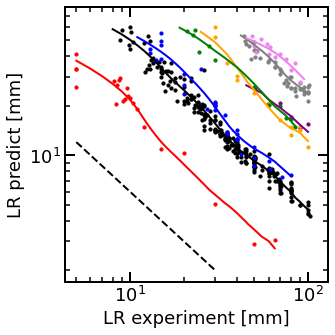

In [22]:
df1 = pd.read_excel('/mnt/c/CEA/data_comp_ppdhasegawa.xlsx')
df2 = pd.read_excel('/mnt/c/CEA/all_mixtureANNC2H2N2C2H2N2OP0LR3.xlsx')
df3 = pd.read_excel('/mnt/c/CEA/all_mixtureANNP0vslrC2H4Ar9.xlsx')

df1 = df1.replace({'Fuel': {'C2H2,acetylene':'C2H2'}})

l = ['Fuel','Diluent','P0', 'H0[KJ/kg]', 'M0[kg/kmol]', 'γ0[-]', 'pcj[bar]', 'Tcj[K]',
       'Hcj[KJ/kg]', 'Mcj[kg/kmol]', 'γcj[-]', 'Mcj[-]', 'Tvn[K]', 'theta']

XpcaFLRDED1 = pd.DataFrame({'P0':df1['P0']})
XpcaFLRDED2 = pd.DataFrame({'P0':df2['P0']})
XpcaFLRDED3 = pd.DataFrame({'P0':df3['P0']})


for i in range(len(l)):
    XpcaFLRDED1[l[i]]=df1[l[i]]

for i in range(len(l)):
    XpcaFLRDED2[l[i]]=df2[l[i]]

for i in range(len(l)):
    XpcaFLRDED3[l[i]]=df3[l[i]]    

XpcaFLRDED1 = XpcaFLRDED1[~( XpcaFLRDED1['theta'] == 0)]
XpcaFLRDED2 = XpcaFLRDED2[~( XpcaFLRDED2['theta'] == 0)]
XpcaFLRDED3 = XpcaFLRDED3[~( XpcaFLRDED3['theta'] == 0)]

dfH2P0 = XpcaFLRDED1[(XpcaFLRDED1['Fuel'] == 'H2')]
dfH2P0 = dfH2P0.query('1.05>P0>0.40')
XH2P0=dfH2P0.drop(columns=['Fuel','Diluent'])

dfC2H2P0 = XpcaFLRDED1[(XpcaFLRDED1['Fuel'] == 'C2H2') & (XpcaFLRDED1['Diluent'].isnull()) ]
dfC2H2P0 = dfC2H2P0.query('0.7>P0>0.03')
XC2H2P0=dfC2H2P0.drop(columns=['Fuel','Diluent'])

dfC2H2ARP0 = XpcaFLRDED1[(XpcaFLRDED1['Fuel'] == 'C2H2') & (XpcaFLRDED1['Diluent'] == 'Ar')]
dfC2H2ARP0 = dfC2H2ARP0.query('1.05>P0>0.07')
XC2H2ARP0 = dfC2H2ARP0.drop(columns=['Fuel','Diluent'])

dfC2H2N2P0 = XpcaFLRDED2[(XpcaFLRDED2['Fuel'] == 'C2H2') & (XpcaFLRDED2['Diluent'] == 'N2')]
dfC2H2N2P0 = dfC2H2N2P0.query('1.05>P0>0.4')
XC2H2N2P0 = dfC2H2N2P0.drop(columns=['Fuel','Diluent'])

dfC2H4P0 = XpcaFLRDED1[(XpcaFLRDED1['Fuel'] == 'C2H4') & (XpcaFLRDED1['Diluent'].isnull()) ]
dfC2H4P0 = dfC2H4P0.query('0.83>P0>0.10')
XC2H4P0 = dfC2H4P0.drop(columns=['Fuel','Diluent'])

dfC2H4ARP0 = XpcaFLRDED3[(XpcaFLRDED3['Fuel'] == 'C2H4') & (XpcaFLRDED3['Diluent'] == 'Ar')]
dfC2H4ARP0 = dfC2H4ARP0.query('1.05>P0>0.2')
XC2H4ARP0 = dfC2H4ARP0.drop(columns=['Fuel','Diluent'])

dfC2H6P0 = XpcaFLRDED1[(XpcaFLRDED1['Fuel'] == 'C2H6') & (XpcaFLRDED1['Diluent'].isnull()) ]
dfC2H6P0 = dfC2H6P0.query('0.88>P0>0.18')
XC2H6P0 = dfC2H6P0.drop(columns=['Fuel','Diluent'])

dfC2H6N2OP0 = XpcaFLRDED2[(XpcaFLRDED2['Fuel'] == 'C2H6') & (XpcaFLRDED2['Diluent'].isnull()) ]
dfC2H6N2OP0 = dfC2H6N2OP0.query('1>P0>0.4')
XC2H6N2OP0 = dfC2H6N2OP0.drop(columns=['Fuel','Diluent'])


sXH2P0 = ss.transform(XH2P0)
sXC2H2P0 = ss.transform(XC2H2P0)
sXC2H2ARP0 = ss.transform(XC2H2ARP0)
sXC2H2N2P0 = ss.transform(XC2H2N2P0)
sXC2H4P0 = ss.transform(XC2H4P0)
sXC2H4ARP0 = ss.transform(XC2H4ARP0)
sXC2H6P0 = ss.transform(XC2H6P0)
sXC2H6N2OP0 = ss.transform(XC2H6N2OP0)

resultH2P0 = grid1.predict(sXH2P0)
resultC2H2P0 = grid1.predict(sXC2H2P0)
resultC2H2ARP0 = grid1.predict(sXC2H2ARP0)
resultC2H2N2P0 = grid1.predict(sXC2H2N2P0)
resultC2H4P0 = grid1.predict(sXC2H4P0)
resultC2H4ARP0 = grid1.predict(sXC2H4ARP0)
resultC2H6P0 = grid1.predict(sXC2H6P0)
resultC2H6N2OP0 = grid1.predict(sXC2H6N2OP0)

def calc_double(n):
    return n*100



XH2testP0 = XpcaFLRDED[( XpcaFLRDED['Fuel'] == 'H2') & ( XpcaFLRDED['Equivalentratio'] == 1)]
XC2H2testP0 = XpcaFLRDED[( XpcaFLRDED['Fuel'] == 'C2H2') & ( XpcaFLRDED['Equivalentratio'] == 1) & ( XpcaFLRDED['Diluent'].isnull())]
XC2H2ARtestP0 = XpcaFLRDED[( XpcaFLRDED['Fuel'] == 'C2H2') & ( XpcaFLRDED['diluentratio'] == 50) & ( XpcaFLRDED['Diluent']=='Ar')]
XC2H2N2testP0 = XpcaFLRDED[( XpcaFLRDED['Fuel'] == 'C2H2') & ( XpcaFLRDED['diluentratio'] == 50) & ( XpcaFLRDED['Diluent']=='N2' )]
XC2H4testP0 = XpcaFLRDED[( XpcaFLRDED['Fuel'] == 'C2H4') & ( XpcaFLRDED['Equivalentratio'] == 1) & ( XpcaFLRDED['Diluent'].isnull())]
XC2H4ARtestP0 = XpcaFLRDED[( XpcaFLRDED['Fuel'] == 'C2H4') & ( XpcaFLRDED['diluentratio'] == 50) & ( XpcaFLRDED['Diluent']=='Ar' )]
XC2H6testP0 = XpcaFLRDED[( XpcaFLRDED['Fuel'] == 'C2H6') & ( XpcaFLRDED['Equivalentratio'] == 1) & ( XpcaFLRDED['Oxidizer']=='O2')]
XC2H6N2OtestP0 = XpcaFLRDED[( XpcaFLRDED['Fuel'] == 'C2H6') & ( XpcaFLRDED['Equivalentratio'] == 1) & ( XpcaFLRDED['Oxidizer']=='N2O')]


XH2testP0['P0'] = list(map(calc_double,XH2testP0['P0']))
XH2P0['P0'] = list(map(calc_double,XH2P0['P0']))
XC2H2testP0['P0']= list(map(calc_double,XC2H2testP0['P0']))
XC2H2P0['P0'] = list(map(calc_double,XC2H2P0['P0']))
XC2H2ARtestP0['P0'] = list(map(calc_double,XC2H2ARtestP0['P0']))
XC2H2ARP0['P0'] = list(map(calc_double,XC2H2ARP0['P0']))
XC2H2N2testP0['P0'] = list(map(calc_double,XC2H2N2testP0['P0']))
XC2H2N2P0['P0'] = list(map(calc_double,XC2H2N2P0['P0']))
XC2H4testP0['P0'] = list(map(calc_double,XC2H4testP0['P0']))
XC2H4P0['P0']= list(map(calc_double,XC2H4P0['P0']))
XC2H4ARtestP0['P0'] = list(map(calc_double,XC2H4ARtestP0['P0']))
XC2H4ARP0['P0'] = list(map(calc_double,XC2H4ARP0['P0']))
XC2H6testP0['P0'] = list(map(calc_double,XC2H6testP0['P0']))
XC2H6P0['P0'] = list(map(calc_double,XC2H6P0['P0']))
XC2H6N2OtestP0['P0'] = list(map(calc_double,XC2H6N2OtestP0['P0']))
XC2H6N2OP0['P0'] = list(map(calc_double,XC2H6N2OP0['P0']))

plt.figure(figsize=(5,5))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5

plt.scatter(XH2testP0['P0'],XH2testP0['Lr'],s=10,color='grey')
plt.plot(XH2P0['P0'],resultH2P0,color='grey')

plt.scatter(XC2H2testP0['P0'],XC2H2testP0['Lr'],s=10,color='red')
plt.plot(XC2H2P0['P0'],resultC2H2P0,color='red')

plt.scatter( XC2H2ARtestP0['P0'], XC2H2ARtestP0['Lr'],s=10 , color='black' )
plt.plot( XC2H2ARP0['P0'], resultC2H2ARP0, color='black' )

plt.scatter( XC2H2N2testP0['P0'], XC2H2N2testP0['Lr'],s=10 , color='purple')
plt.plot( XC2H2N2P0['P0'], resultC2H2N2P0, color='purple' )

plt.scatter(XC2H4testP0['P0'],XC2H4testP0['Lr'],s=10,color='blue')
plt.plot(XC2H4P0['P0'],resultC2H4P0,color='blue')

plt.scatter(XC2H4ARtestP0['P0'],XC2H4ARtestP0['Lr'],s=10,color='orange')
plt.plot(XC2H4ARP0['P0'],resultC2H4ARP0,color='orange')

plt.scatter(XC2H6testP0['P0'],XC2H6testP0['Lr'],s=10,color='green')
plt.plot(XC2H6P0['P0'],resultC2H6P0,color='green')

plt.scatter(XC2H6N2OtestP0['P0'],XC2H6N2OtestP0['Lr'],s=10,color='violet')
plt.plot(XC2H6N2OP0['P0'],resultC2H6N2OP0,color='violet')

x = np.linspace(5, 30, 10)
y = 60/x
plt.plot(x,y,color='black',linestyle='dashed')
ax = plt.gca()
#ax.spines['top'].set_color('none')
##
ax.set_yscale('log')  # メイン: y軸をlogスケールで描く
ax.set_xscale('log')
plt.xlim(0, 130)
plt.ylim(0, 80)
#plt.xticks(np.arange(0, 101, step=50))
#plt.yticks(np.arange(0, 161, step=40))
plt.xlabel('LR experiment [mm]')
plt.ylabel('LR predict [mm]')
plt.tight_layout()
plt.savefig("gurafu5.png")

希釈率と反射点距離

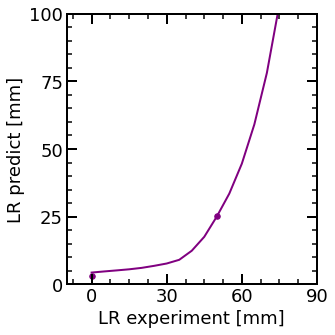

In [38]:
df4 = pd.read_excel('/mnt/c/CEA/all_mixtureANNP050vsdiluent4.xlsx')

l4 = ['Fuel','Diluent','diluentratio','P0', 'H0[KJ/kg]', 'M0[kg/kmol]', 'γ0[-]', 'pcj[bar]', 'Tcj[K]',
       'Hcj[KJ/kg]', 'Mcj[kg/kmol]', 'γcj[-]', 'Mcj[-]', 'Tvn[K]', 'theta']

XpcaFLRDED4 = pd.DataFrame({'P0':df4['P0']})

for i in range(len(l4)):
    XpcaFLRDED4[l4[i]]=df4[l4[i]]

XpcaFLRDED4 = XpcaFLRDED4[~( XpcaFLRDED4['theta'] == 0)]

dfC2H2ARdi = XpcaFLRDED4[(XpcaFLRDED4['Fuel'] == 'C2H2')]
XC2H2ARdi = dfC2H2ARdi.drop(columns=['Fuel','Diluent','diluentratio'])

dfC2H4ARdi = XpcaFLRDED4[(XpcaFLRDED4['Fuel'] == 'C2H4')]
XC2H4ARdi = dfC2H4ARdi.drop(columns=['Fuel','Diluent','diluentratio'])

dfC2H2N2di = XpcaFLRDED4[(XpcaFLRDED4['Fuel'] == 'C2H2N2')]
XC2H2N2di = dfC2H2N2di.drop(columns=['Fuel','Diluent','diluentratio'])

sXC2H2ARdi = ss.transform(XC2H2ARdi)
sXC2H4ARdi = ss.transform(XC2H4ARdi)
sXC2H2N2di = ss.transform(XC2H2N2di)

resultC2H2ARdi = grid1.predict(sXC2H2ARdi)
resultC2H4ARdi = grid1.predict(sXC2H4ARdi)
resultC2H2N2di = grid1.predict(sXC2H2N2di)

dfC2H2exdi = XpcaFLRDED[(XpcaFLRDED['Fuel'] == 'C2H2') & (XpcaFLRDED['Diluent'].isnull()) & (XpcaFLRDED['Equivalentratio'] == 1)]
dfC2H2exdi = dfC2H2exdi.query('0.55>P0>0.45')

dfC2H4exdi = XpcaFLRDED[(XpcaFLRDED['Fuel'] == 'C2H4') & (XpcaFLRDED['Diluent'].isnull())  & (XpcaFLRDED['Equivalentratio'] == 1)]
dfC2H4exdi = dfC2H4exdi.query('0.55>P0>0.45')

dfC2H2ARexdi = XpcaFLRDED[(XpcaFLRDED['Fuel'] == 'C2H2') & (XpcaFLRDED['Equivalentratio'] == 1) & ( XpcaFLRDED['Diluent'] == 'Ar') ]
dfC2H2ARexdi = dfC2H2ARexdi.query('0.55>P0>0.45')

dfC2H2N2exdi = XpcaFLRDED[(XpcaFLRDED['Fuel'] == 'C2H2') & (XpcaFLRDED['Equivalentratio'] == 1) & ( XpcaFLRDED['Diluent'] == 'N2') ]
dfC2H2N2exdi = dfC2H2N2exdi.query('0.55>P0>0.45')

dfC2H4ARexdi = XpcaFLRDED[(XpcaFLRDED['Fuel'] == 'C2H4') & (XpcaFLRDED['Equivalentratio'] == 1) & ( XpcaFLRDED['Diluent'] == 'Ar') ]
dfC2H4ARexdi = dfC2H4ARexdi.query('0.55>P0>0.45')

plt.figure(figsize=(5,5))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5


#plt.scatter(dfC2H4exdi['diluentratio'],dfC2H4exdi['Lr'],s=30,color='orange')
#plt.scatter(dfC2H4ARexdi['diluentratio'],dfC2H4ARexdi['Lr'],s=30,color='orange')

plt.scatter(dfC2H2exdi['diluentratio'],dfC2H2exdi['Lr'],s=30,color='purple')
#plt.scatter(dfC2H2ARexdi['diluentratio'],dfC2H2ARexdi['Lr'],s=30,color='black')
plt.scatter(dfC2H2N2exdi['diluentratio'],dfC2H2N2exdi['Lr'],s=30,color='purple')


#plt.plot(dfC2H2ARdi['diluentratio'],resultC2H2ARdi,color='black')
#plt.plot(dfC2H4ARdi['diluentratio'],resultC2H4ARdi,color='orange')
plt.plot(dfC2H2N2di['diluentratio'],resultC2H2N2di,color='purple')

plt.xlim(-10, 90)
plt.ylim(0, 100)
plt.xticks(np.arange(0, 91, step=30))
plt.yticks(np.arange(0, 101, step=25))
plt.xlabel('LR experiment [mm]')
plt.ylabel('LR predict [mm]')
plt.tight_layout()
plt.savefig("gurafu7.png")

反射点距離と等量比

In [39]:
df5 = pd.read_excel('/mnt/c/CEA/all_mixtureANNfaivsLR2.xlsx')

l5 = ['Fuel','Equivalentratio','P0', 'H0[KJ/kg]', 'M0[kg/kmol]', 'γ0[-]', 'pcj[bar]', 'Tcj[K]',
       'Hcj[KJ/kg]', 'Mcj[kg/kmol]', 'γcj[-]', 'Mcj[-]', 'Tvn[K]', 'theta']

XpcaFLRDED5 = pd.DataFrame({'P0':df5['P0']})

for i in range(len(l5)):
    XpcaFLRDED5[l5[i]]=df5[l5[i]]

XpcaFLRDED5 = XpcaFLRDED5[~( XpcaFLRDED5['theta'] == 0)]

dfH2fai = XpcaFLRDED5[(XpcaFLRDED5['Fuel'] == 'H2')]
XH2fai = dfH2fai.drop(columns=['Fuel','Equivalentratio'])

dfC2H2fai = XpcaFLRDED5[(XpcaFLRDED5['Fuel'] == 'C2H2')]
XC2H2fai = dfC2H2fai.drop(columns=['Fuel','Equivalentratio'])

dfC2H4fai = XpcaFLRDED5[(XpcaFLRDED5['Fuel'] == 'C2H4')]
XC2H4fai = dfC2H4fai.drop(columns=['Fuel','Equivalentratio'])

dfC2H6fai = XpcaFLRDED5[(XpcaFLRDED5['Fuel'] == 'C2H6')]
XC2H6fai = dfC2H6fai.drop(columns=['Fuel','Equivalentratio'])

sXH2fai = ss.transform(XH2fai)
sXC2H2fai = ss.transform(XC2H2fai)
sXC2H4fai = ss.transform(XC2H4fai)
sXC2H6fai = ss.transform(XC2H6fai)

resultH2fai = grid1.predict(sXH2fai)
resultC2H2fai = grid1.predict(sXC2H2fai)
resultC2H4fai = grid1.predict(sXC2H4fai)
resultC2H6fai = grid1.predict(sXC2H6fai)

dfH2exfai = XpcaFLRDED[(XpcaFLRDED['Fuel'] == 'H2') & (XpcaFLRDED['Diluent'].isnull())]
dfH2exfai = dfH2fai.query('0.55>P0>0.45')

dfC2H2exfai = XpcaFLRDED[(XpcaFLRDED['Fuel'] == 'C2H2') & (XpcaFLRDED['Diluent'].isnull())]
dfC2H2exfai = dfC2H2exfai.query('0.55>P0>0.45')

dfC2H4exfai = XpcaFLRDED[(XpcaFLRDED['Fuel'] == 'C2H4') & (XpcaFLRDED['Diluent'].isnull())]
dfC2H4exfai = dfC2H4exfai.query('0.55>P0>0.45')

dfC2H6exfai = XpcaFLRDED[(XpcaFLRDED['Fuel'] == 'C2H6') & (XpcaFLRDED['Diluent'].isnull())]
dfC2H6exfai = dfC2H6exfai.query('0.55>P0>0.45')

plt.figure(figsize=(5,5))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5

plt.scatter(dfH2exfai['Equivalentratio'],dfH2exfai['Lr'],s=30,color='grey')
plt.scatter(dfC2H2exfai['Equivalentratio'],dfC2H2exfai['Lr'],s=30,color='red')
plt.scatter(dfC2H4exfai['Equivalentratio'],dfC2H4exfai['Lr'],s=30,color='blue')
plt.scatter(dfC2H6exfai['Equivalentratio'],dfC2H6exfai['Lr'],s=30,color='green')

plt.plot(dfH2fai['Equivalentratio'],resultH2fai,color='grey')
plt.plot(dfC2H2fai['Equivalentratio'],resultC2H2fai,color='red')
plt.plot(dfC2H4fai['Equivalentratio'],resultC2H4fai,color='blue')
plt.plot(dfC2H6fai['Equivalentratio'],resultC2H6fai,color='green')

plt.xlim(0.4,1.6)
plt.ylim(0, 100)
plt.xticks(np.arange(0.4, 1.6, step=0.4))
plt.yticks(np.arange(0, 101, step=25))
plt.xlabel('LR experiment [mm]')
plt.ylabel('LR predict [mm]')
plt.tight_layout()
plt.savefig("gurafu7.png")

ValueError: Found array with 0 sample(s) (shape=(0, 12)) while a minimum of 1 is required by StandardScaler.

5.2.2　重要な特徴量

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


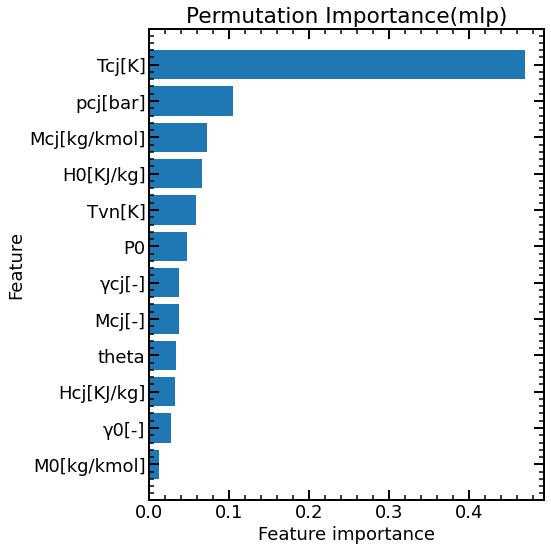

In [ ]:
#all
def plot_feature_importance(df):
    n_features = len(df)
    df_plot = df.sort_values('importance')
    f_importance_plot = df_plot['importance'].values
    plt.barh(range(n_features), f_importance_plot, align='center')
    cols_plot = df_plot['feature'].values
    plt.yticks(np.arange(n_features), cols_plot)
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

result = permutation_importance(grid1,sX_trainval,y_trainval, n_repeats=5, random_state=42)

cols = list(sX_trainval.columns)         # 特徴量名のリスト(目的変数CRIM以外)
f_importance = np.array(result["importances"].mean(axis=1)) # 特徴量重要度の算出
f_importance = f_importance / np.sum(f_importance)  # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df1=df_importance
df_importance = df_importance.sort_values("importance",ascending=False)

plt.figure(figsize=(8,8))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

# Tick Setting
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.top'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
#sns.barplot(x="Importance", y="Features",data=df_importance,ci=None)
plot_feature_importance(df_importance)
plt.title("Permutation Importance(mlp)")
plt.tight_layout()
plt.savefig("gurafu11.png")


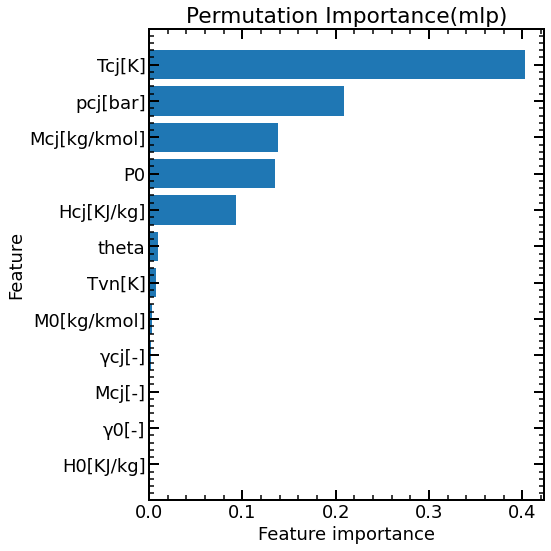

In [ ]:
#H2/O2
result = permutation_importance(grid1,sXH2trainval,yH2trainval, n_repeats=5, random_state=42)

cols = list(sX_trainval.columns)         # 特徴量名のリスト(目的変数CRIM以外)
f_importance = np.array(result["importances"].mean(axis=1)) # 特徴量重要度の算出
f_importance = f_importance / np.sum(f_importance)  # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df1=df_importance
df_importance = df_importance.sort_values("importance",ascending=False)

plt.figure(figsize=(8,8))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

# Tick Setting
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.top'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
#sns.barplot(x="Importance", y="Features",data=df_importance,ci=None)
plot_feature_importance(df_importance)
plt.title("Permutation Importance(mlp)")
plt.tight_layout()
plt.savefig("gurafu12.png")

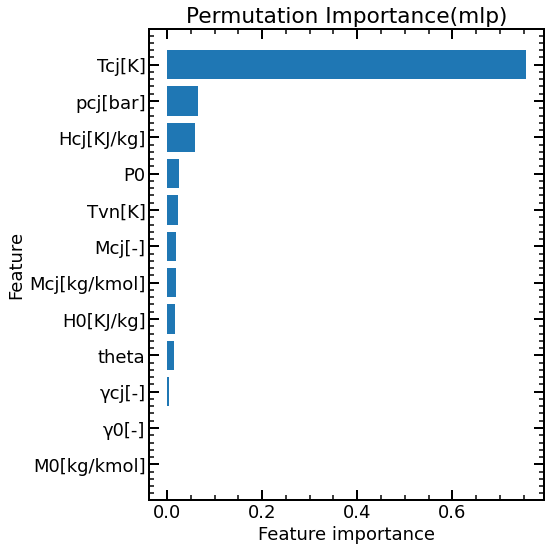

In [ ]:
#C2H2/O2
result = permutation_importance(grid1,sXC2H2trainval,yC2H2trainval, n_repeats=5, random_state=42)

cols = list(sX_trainval.columns)         # 特徴量名のリスト(目的変数CRIM以外)
f_importance = np.array(result["importances"].mean(axis=1)) # 特徴量重要度の算出
f_importance = f_importance / np.sum(f_importance)  # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df1=df_importance
df_importance = df_importance.sort_values("importance",ascending=False)

plt.figure(figsize=(8,8))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

# Tick Setting
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.top'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
#sns.barplot(x="Importance", y="Features",data=df_importance,ci=None)
plot_feature_importance(df_importance)
plt.title("Permutation Importance(mlp)")
plt.tight_layout()
plt.savefig("gurafu13.png")

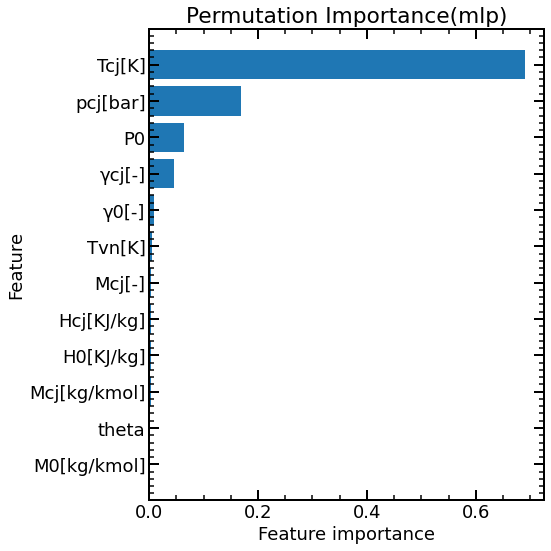

In [ ]:
#C2H2/O2/AR
result = permutation_importance(grid1,sXC2H2ARtrainval,yC2H2ARtrainval, n_repeats=5, random_state=42)

cols = list(sX_trainval.columns)         # 特徴量名のリスト(目的変数CRIM以外)
f_importance = np.array(result["importances"].mean(axis=1)) # 特徴量重要度の算出
f_importance = f_importance / np.sum(f_importance)  # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df1=df_importance
df_importance = df_importance.sort_values("importance",ascending=False)

plt.figure(figsize=(8,8))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

# Tick Setting
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.top'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
#sns.barplot(x="Importance", y="Features",data=df_importance,ci=None)
plot_feature_importance(df_importance)
plt.title("Permutation Importance(mlp)")
plt.tight_layout()
plt.savefig("gurafu14.png")

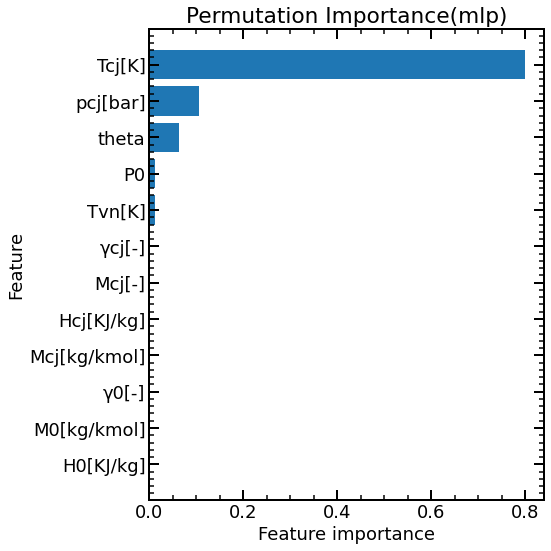

In [ ]:
#C2H2/O2/N2
result = permutation_importance(grid1,sXC2H2N2trainval,yC2H2N2trainval, n_repeats=5, random_state=42)

cols = list(sX_trainval.columns)         # 特徴量名のリスト(目的変数CRIM以外)
f_importance = np.array(result["importances"].mean(axis=1)) # 特徴量重要度の算出
f_importance = f_importance / np.sum(f_importance)  # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df1=df_importance
df_importance = df_importance.sort_values("importance",ascending=False)

plt.figure(figsize=(8,8))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

# Tick Setting
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.top'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
#sns.barplot(x="Importance", y="Features",data=df_importance,ci=None)
plot_feature_importance(df_importance)
plt.title("Permutation Importance(mlp)")
plt.tight_layout()
plt.savefig("gurafu15.png")

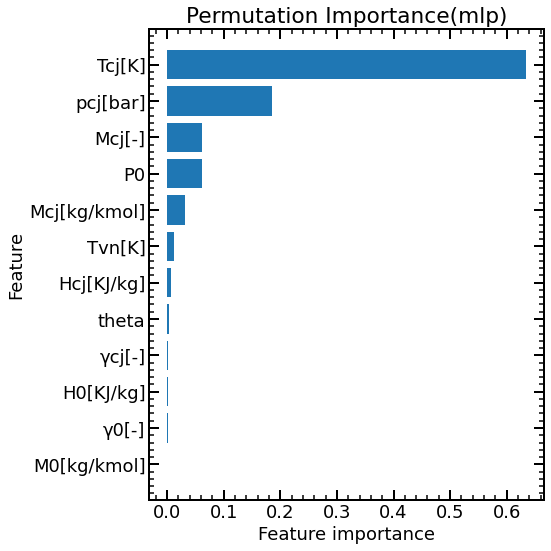

In [ ]:
#C2H4/O2
result = permutation_importance(grid1,sXC2H4trainval,yC2H4trainval, n_repeats=5, random_state=42)

cols = list(sX_trainval.columns)         # 特徴量名のリスト(目的変数CRIM以外)
f_importance = np.array(result["importances"].mean(axis=1)) # 特徴量重要度の算出
f_importance = f_importance / np.sum(f_importance)  # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df1=df_importance
df_importance = df_importance.sort_values("importance",ascending=False)

plt.figure(figsize=(8,8))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

# Tick Setting
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.top'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
#sns.barplot(x="Importance", y="Features",data=df_importance,ci=None)
plot_feature_importance(df_importance)
plt.title("Permutation Importance(mlp)")
plt.tight_layout()
plt.savefig("gurafu16.png")

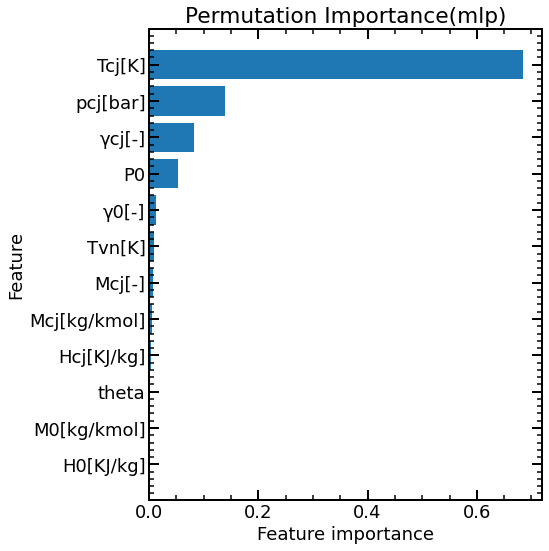

In [ ]:
#C2H4/O2/AR
result = permutation_importance(grid1,sXC2H4ARtrainval,yC2H4ARtrainval, n_repeats=5, random_state=42)

cols = list(sX_trainval.columns)         # 特徴量名のリスト(目的変数CRIM以外)
f_importance = np.array(result["importances"].mean(axis=1)) # 特徴量重要度の算出
f_importance = f_importance / np.sum(f_importance)  # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df1=df_importance
df_importance = df_importance.sort_values("importance",ascending=False)

plt.figure(figsize=(8,8))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

# Tick Setting
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.top'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
#sns.barplot(x="Importance", y="Features",data=df_importance,ci=None)
plot_feature_importance(df_importance)
plt.title("Permutation Importance(mlp)")
plt.tight_layout()
plt.savefig("gurafu17.png")

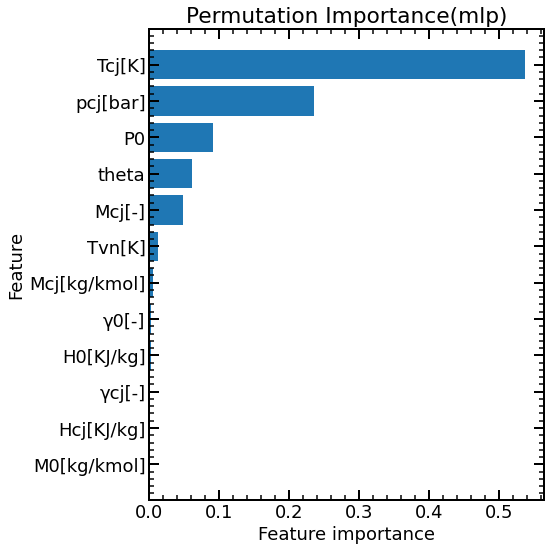

In [ ]:
#C2H6/O2
result = permutation_importance(grid1,sXC2H6trainval,yC2H6trainval, n_repeats=5, random_state=42)

cols = list(sX_trainval.columns)         # 特徴量名のリスト(目的変数CRIM以外)
f_importance = np.array(result["importances"].mean(axis=1)) # 特徴量重要度の算出
f_importance = f_importance / np.sum(f_importance)  # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df1=df_importance
df_importance = df_importance.sort_values("importance",ascending=False)

plt.figure(figsize=(8,8))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

# Tick Setting
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.top'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
#sns.barplot(x="Importance", y="Features",data=df_importance,ci=None)
plot_feature_importance(df_importance)
plt.title("Permutation Importance(mlp)")
plt.tight_layout()
plt.savefig("gurafu18.png")

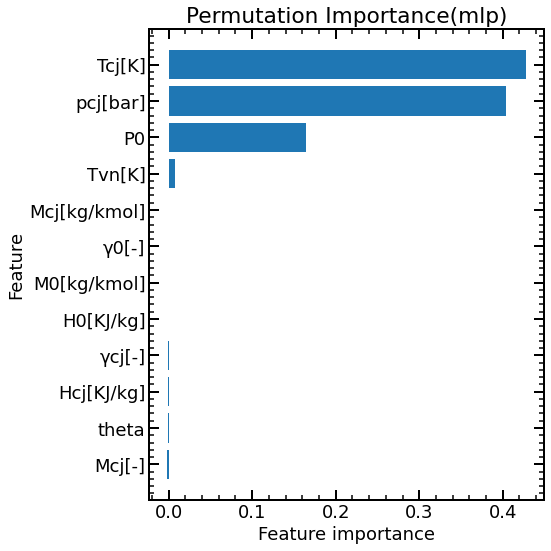

In [ ]:
#C2H6/N2O
result = permutation_importance(grid1,sXC2H6N2Otrainval,yC2H6N2Otrainval, n_repeats=5, random_state=42)

cols = list(sX_trainval.columns)         # 特徴量名のリスト(目的変数CRIM以外)
f_importance = np.array(result["importances"].mean(axis=1)) # 特徴量重要度の算出
f_importance = f_importance / np.sum(f_importance)  # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df1=df_importance
df_importance = df_importance.sort_values("importance",ascending=False)

plt.figure(figsize=(8,8))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

# Tick Setting
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.top'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
#sns.barplot(x="Importance", y="Features",data=df_importance,ci=None)
plot_feature_importance(df_importance)
plt.title("Permutation Importance(mlp)")
plt.tight_layout()
plt.savefig("gurafu19.png")

5.2.3 反応誘導長と特徴量の関係

In [ ]:
y_induction = dftrainval['inductionlength']
yH2induction = dfH2trainval['inductionlength']
yC2H2induction = dfC2H2trainval['inductionlength']
yC2H2ARinduction = dfC2H2ARtrainval['inductionlength']
yC2H2N2induction = dfC2H2N2trainval['inductionlength']
yC2H4induction = dfC2H4trainval['inductionlength']
yC2H4ARinduction = dfC2H4ARtrainval['inductionlength']
yC2H6induction = dfC2H6trainval['inductionlength']
yC2H6N2Oinduction = dfC2H6N2Otrainval['inductionlength']

def calc_double(n):
    return n*100000
y_induction =list(map(calc_double,y_induction))
yH2induction =list(map(calc_double,yH2induction))
yC2H2induction =list(map(calc_double,yC2H2induction))
yC2H2ARinduction =list(map(calc_double,yC2H2ARinduction))
yC2H2N2induction =list(map(calc_double,yC2H2N2induction))
yC2H4induction =list(map(calc_double,yC2H4induction))
yC2H4ARinduction =list(map(calc_double,yC2H4ARinduction))
yC2H6induction =list(map(calc_double,yC2H6induction))
yC2H6N2Oinduction =list(map(calc_double,yC2H6N2Oinduction))

In [ ]:
sol = ['adam']
act = ['relu']
hidd = []

for i in [6]:
    for j in [200]:
        b=[j]*i
        b=tuple(b)
        hidd.append(b)

alp=[1e-2]
param_grid = {'solver':sol,'activation':act,'hidden_layer_sizes':hidd,'alpha':alp}
grid2 = GridSearchCV(MLPRegressor(), param_grid ,cv=2, n_jobs=4)
grid2.fit(sX_trainval,y_induction)

print('Best parameters: {}'.format(grid1.best_params_))
print('Best cross-validation: {}'.format(grid1.best_score_))

Best parameters: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (200, 200, 200, 200), 'solver': 'adam'}
Best cross-validation: 0.9454759122287303


                 MSE        R2  len
H2          4.850514 -0.002805  121
C2H2      157.088046 -7.808589  123
C2H2AR   1235.016904  0.945453  245
C2H2N2      5.443952  0.438504    6
C2H4        1.715504  0.921142   82
C2H4AR     20.965268 -2.791327   72
C2H6        1.522488  0.944385   67
C2H6N2O    15.022827  0.169074   13


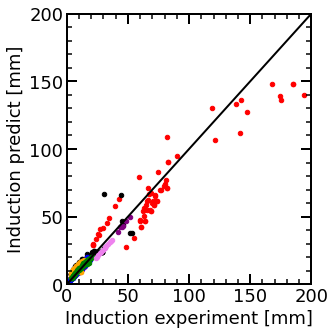

In [ ]:
resultH2 = grid2.predict(sXH2trainval)
MSEH2 = mean_squared_error(yH2induction, resultH2)
R2H2 = r2_score(yH2induction,resultH2)

resultC2H2 = grid2.predict(sXC2H2trainval)
MSEC2H2 = mean_squared_error(yC2H2induction, resultC2H2)
R2C2H2 = r2_score(yC2H2trainval,resultC2H2)

resultC2H2AR = grid2.predict(sXC2H2ARtrainval)
MSEC2H2AR = mean_squared_error(yC2H2ARinduction, resultC2H2AR)
R2C2H2AR = r2_score(yC2H2ARinduction,resultC2H2AR)

resultC2H2N2 = grid2.predict(sXC2H2N2trainval)
MSEC2H2N2 = mean_squared_error(yC2H2N2induction, resultC2H2N2)
R2C2H2N2 = r2_score(yC2H2N2induction,resultC2H2N2)

resultC2H4 = grid2.predict(sXC2H4trainval)
MSEC2H4 = mean_squared_error(yC2H4induction, resultC2H4)
R2C2H4 = r2_score(yC2H4induction,resultC2H4)

resultC2H4AR = grid2.predict(sXC2H4ARtrainval)
MSEC2H4AR = mean_squared_error(yC2H4ARinduction, resultC2H4AR)
R2C2H4AR = r2_score(yC2H4ARinduction, resultC2H4AR)

resultC2H6 = grid2.predict(sXC2H6trainval)
MSEC2H6 = mean_squared_error(yC2H6induction, resultC2H6)
R2C2H6 = r2_score(yC2H6induction,resultC2H6)

resultC2H6N2O = grid2.predict(sXC2H6N2Otrainval)
MSEC2H6N2O = mean_squared_error(yC2H6N2Oinduction, resultC2H6N2O)
R2C2H6N2O = r2_score(yC2H6N2Oinduction, resultC2H6N2O)

print(pd.DataFrame([[MSEH2,R2H2,len(yH2trainval)], [MSEC2H2,R2C2H2,len(yC2H2trainval)],[MSEC2H2AR, R2C2H2AR,len(yC2H2ARtrainval)],[MSEC2H2N2, R2C2H2N2,len(yC2H2N2trainval)], [MSEC2H4, R2C2H4,len(yC2H4trainval)],[MSEC2H4AR, R2C2H4AR,len(yC2H4ARtrainval)],[MSEC2H6, R2C2H6,len(yC2H6trainval)],[MSEC2H6N2O, R2C2H6N2O,len(yC2H6N2Otrainval)]],
                   columns=['MSE', 'R2','len'],
                   index=['H2','C2H2','C2H2AR','C2H2N2','C2H4','C2H4AR','C2H6','C2H6N2O']))


plt.figure(figsize=(5,5))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5

plt.plot([0, 200], [0, 200],color='black')

plt.scatter(yH2induction,resultH2,s=20,color='grey')
plt.scatter(yC2H2induction,resultC2H2,s=20,color='red')
plt.scatter(yC2H2ARinduction,resultC2H2AR,s=20,color='black')
plt.scatter(yC2H2N2induction,resultC2H2N2,s=20,color='purple')
plt.scatter(yC2H4induction,resultC2H4,s=20,color='blue')
plt.scatter(yC2H4ARinduction,resultC2H4AR,s=20,color='orange')
plt.scatter(yC2H6induction,resultC2H6,s=20,color='green')
plt.scatter(yC2H6N2Oinduction,resultC2H6N2O,s=20,color='violet')

plt.xlim(0, 200)
plt.ylim(0, 200)
plt.xticks(np.arange(0, 201, step=50))
plt.yticks(np.arange(0, 201, step=50))
plt.xlabel('Induction experiment [mm]')
plt.ylabel('Induction predict [mm]')
plt.tight_layout()
plt.savefig("gurafu10.png")

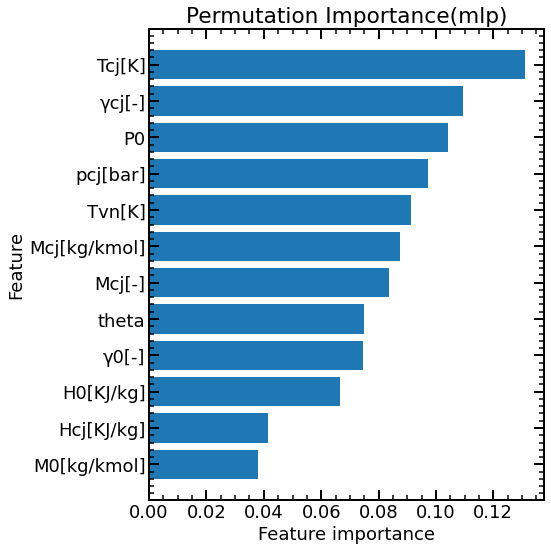

In [ ]:
#all
result = permutation_importance(grid2,sX_trainval,y_induction, n_repeats=5, random_state=42)

cols = list(sX_trainval.columns)         # 特徴量名のリスト(目的変数CRIM以外)
f_importance = np.array(result["importances"].mean(axis=1)) # 特徴量重要度の算出
f_importance = f_importance / np.sum(f_importance)  # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df1=df_importance
df_importance = df_importance.sort_values("importance",ascending=False)

plt.figure(figsize=(8,8))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

# Tick Setting
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.top'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
#sns.barplot(x="Importance", y="Features",data=df_importance,ci=None)
plot_feature_importance(df_importance)
plt.title("Permutation Importance(mlp)")
plt.tight_layout()
plt.savefig("gurafu20.png")

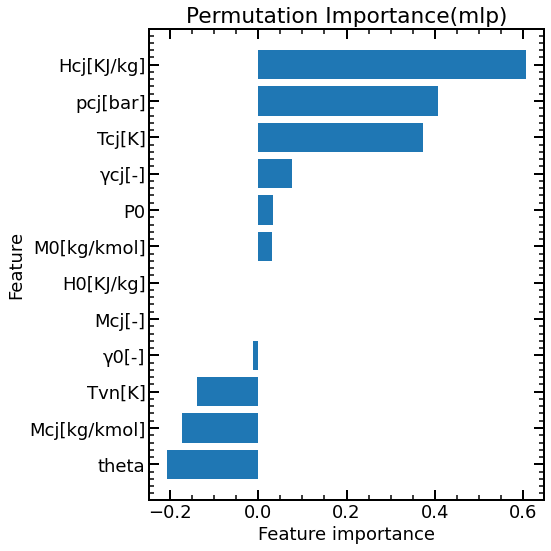

In [ ]:
#H2/O2
result = permutation_importance(grid2,sXH2trainval,yH2induction, n_repeats=5, random_state=42)

cols = list(sX_trainval.columns)         # 特徴量名のリスト(目的変数CRIM以外)
f_importance = np.array(result["importances"].mean(axis=1)) # 特徴量重要度の算出
f_importance = f_importance / np.sum(f_importance)  # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df1=df_importance
df_importance = df_importance.sort_values("importance",ascending=False)

plt.figure(figsize=(8,8))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

# Tick Setting
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.top'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
#sns.barplot(x="Importance", y="Features",data=df_importance,ci=None)
plot_feature_importance(df_importance)
plt.title("Permutation Importance(mlp)")
plt.tight_layout()
plt.savefig("gurafu21.png")

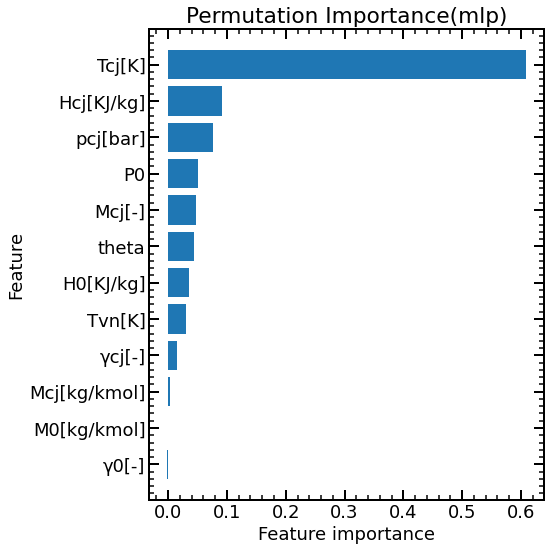

In [ ]:
#C2H2/O2
result = permutation_importance(grid2,sXC2H2trainval,yC2H2induction, n_repeats=5, random_state=42)

cols = list(sX_trainval.columns)         # 特徴量名のリスト(目的変数CRIM以外)
f_importance = np.array(result["importances"].mean(axis=1)) # 特徴量重要度の算出
f_importance = f_importance / np.sum(f_importance)  # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df1=df_importance
df_importance = df_importance.sort_values("importance",ascending=False)

plt.figure(figsize=(8,8))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

# Tick Setting
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.top'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
#sns.barplot(x="Importance", y="Features",data=df_importance,ci=None)
plot_feature_importance(df_importance)
plt.title("Permutation Importance(mlp)")
plt.tight_layout()
plt.savefig("gurafu22.png")

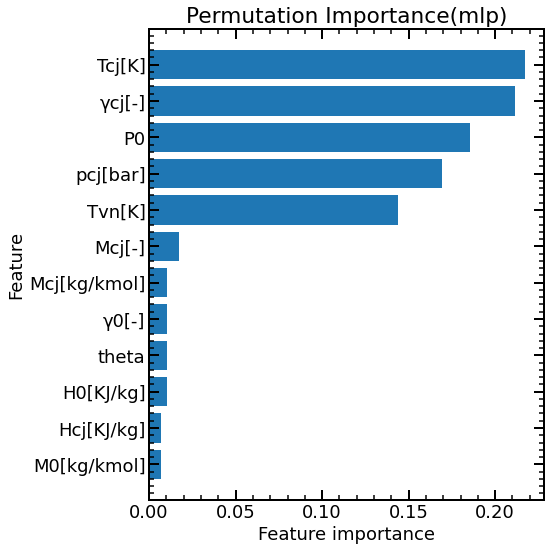

In [ ]:
#C2H2/O2/AR
result = permutation_importance(grid2,sXC2H2ARtrainval,yC2H2ARinduction, n_repeats=5, random_state=42)

cols = list(sX_trainval.columns)         # 特徴量名のリスト(目的変数CRIM以外)
f_importance = np.array(result["importances"].mean(axis=1)) # 特徴量重要度の算出
f_importance = f_importance / np.sum(f_importance)  # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df1=df_importance
df_importance = df_importance.sort_values("importance",ascending=False)

plt.figure(figsize=(8,8))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

# Tick Setting
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.top'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
#sns.barplot(x="Importance", y="Features",data=df_importance,ci=None)
plot_feature_importance(df_importance)
plt.title("Permutation Importance(mlp)")
plt.tight_layout()
plt.savefig("gurafu23.png")

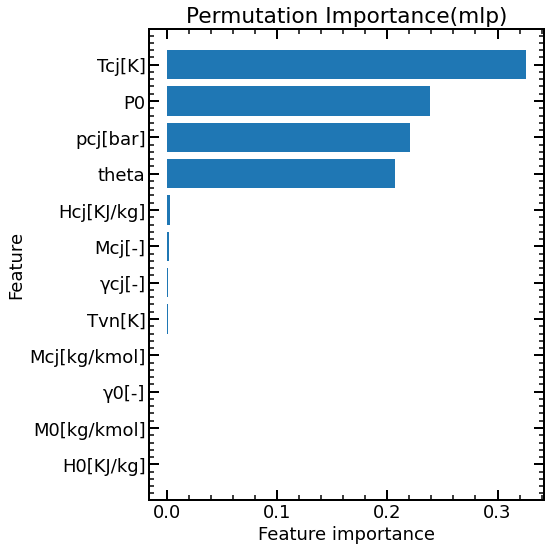

In [ ]:
#C2H2/O2/N2
result = permutation_importance(grid2,sXC2H2N2trainval,yC2H2N2induction, n_repeats=5, random_state=42)

cols = list(sX_trainval.columns)         # 特徴量名のリスト(目的変数CRIM以外)
f_importance = np.array(result["importances"].mean(axis=1)) # 特徴量重要度の算出
f_importance = f_importance / np.sum(f_importance)  # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df1=df_importance
df_importance = df_importance.sort_values("importance",ascending=False)

plt.figure(figsize=(8,8))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

# Tick Setting
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.top'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
#sns.barplot(x="Importance", y="Features",data=df_importance,ci=None)
plot_feature_importance(df_importance)
plt.title("Permutation Importance(mlp)")
plt.tight_layout()
plt.savefig("gurafu24.png")

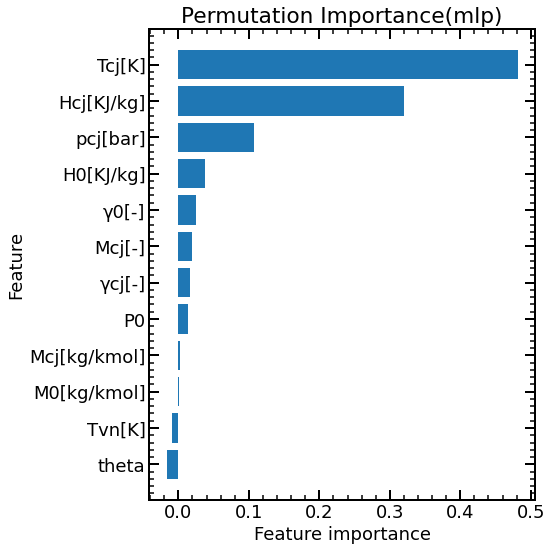

In [ ]:
#C2H4/O2
result = permutation_importance(grid2,sXC2H4trainval,yC2H4induction, n_repeats=5, random_state=42)

cols = list(sX_trainval.columns)         # 特徴量名のリスト(目的変数CRIM以外)
f_importance = np.array(result["importances"].mean(axis=1)) # 特徴量重要度の算出
f_importance = f_importance / np.sum(f_importance)  # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df1=df_importance
df_importance = df_importance.sort_values("importance",ascending=False)

plt.figure(figsize=(8,8))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

# Tick Setting
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.top'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
#sns.barplot(x="Importance", y="Features",data=df_importance,ci=None)
plot_feature_importance(df_importance)
plt.title("Permutation Importance(mlp)")
plt.tight_layout()
plt.savefig("gurafu25.png")

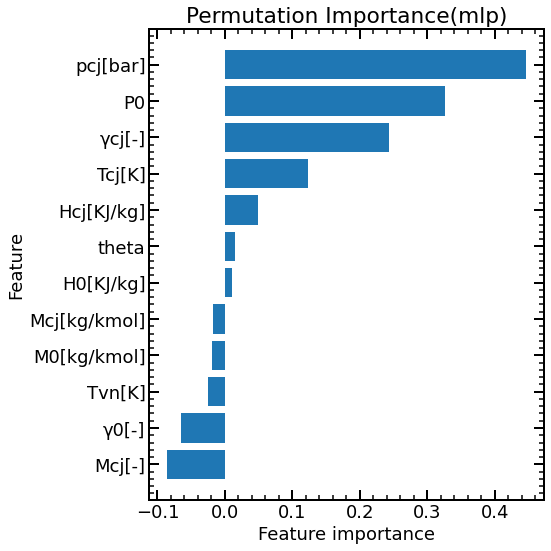

In [ ]:
#aC2H4/O2/AR
result = permutation_importance(grid2,sXC2H4ARtrainval,yC2H4ARinduction, n_repeats=5, random_state=42)

cols = list(sX_trainval.columns)         # 特徴量名のリスト(目的変数CRIM以外)
f_importance = np.array(result["importances"].mean(axis=1)) # 特徴量重要度の算出
f_importance = f_importance / np.sum(f_importance)  # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df1=df_importance
df_importance = df_importance.sort_values("importance",ascending=False)

plt.figure(figsize=(8,8))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

# Tick Setting
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.top'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
#sns.barplot(x="Importance", y="Features",data=df_importance,ci=None)
plot_feature_importance(df_importance)
plt.title("Permutation Importance(mlp)")
plt.tight_layout()
plt.savefig("gurafu26.png")

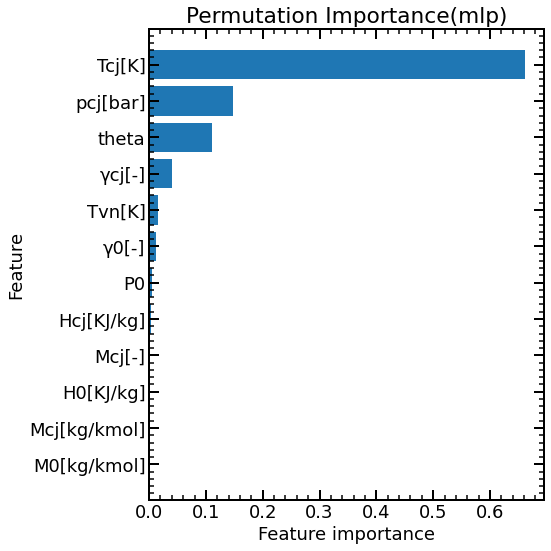

In [ ]:
#C2H6
result = permutation_importance(grid2,sXC2H6trainval,yC2H6induction, n_repeats=5, random_state=42)

cols = list(sX_trainval.columns)         # 特徴量名のリスト(目的変数CRIM以外)
f_importance = np.array(result["importances"].mean(axis=1)) # 特徴量重要度の算出
f_importance = f_importance / np.sum(f_importance)  # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df1=df_importance
df_importance = df_importance.sort_values("importance",ascending=False)

plt.figure(figsize=(8,8))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

# Tick Setting
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.top'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
#sns.barplot(x="Importance", y="Features",data=df_importance,ci=None)
plot_feature_importance(df_importance)
plt.title("Permutation Importance(mlp)")
plt.tight_layout()
plt.savefig("gurafu27.png")

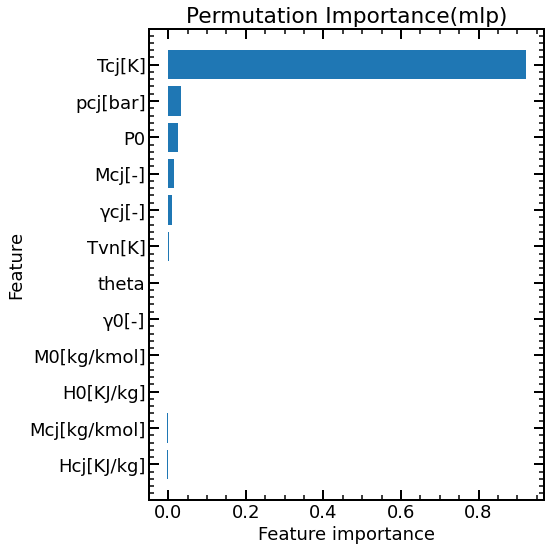

In [ ]:
#C2H6N2O
result = permutation_importance(grid2,sXC2H6N2Otrainval,yC2H6N2Oinduction, n_repeats=5, random_state=42)

cols = list(sX_trainval.columns)         # 特徴量名のリスト(目的変数CRIM以外)
f_importance = np.array(result["importances"].mean(axis=1)) # 特徴量重要度の算出
f_importance = f_importance / np.sum(f_importance)  # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df1=df_importance
df_importance = df_importance.sort_values("importance",ascending=False)

plt.figure(figsize=(8,8))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

# Tick Setting
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.top'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
#sns.barplot(x="Importance", y="Features",data=df_importance,ci=None)
plot_feature_importance(df_importance)
plt.title("Permutation Importance(mlp)")
plt.tight_layout()
plt.savefig("gurafu28.png")

5.2.4 反射点距離と反応誘導長と特徴量の関係性

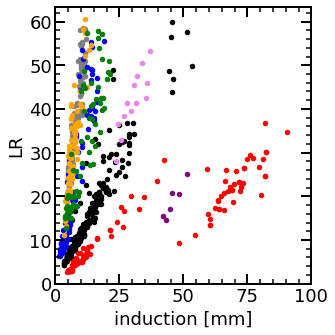

In [ ]:
plt.figure(figsize=(5,5))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5

plt.scatter(yH2induction,yH2trainval,s=20,color='grey')
plt.scatter(yC2H2induction,yC2H2trainval,s=20,color='red')
plt.scatter(yC2H2ARinduction,yC2H2ARtrainval,s=20,color='black')
plt.scatter(yC2H2N2induction,yC2H2N2trainval,s=20,color='purple')
plt.scatter(yC2H4induction,yC2H4trainval,s=20,color='blue')
plt.scatter(yC2H4ARinduction,yC2H4ARtrainval,s=20,color='orange')
plt.scatter(yC2H6induction,yC2H6trainval,s=20,color='green')
plt.scatter(yC2H6N2Oinduction,yC2H6N2Otrainval,s=20,color='violet')

plt.xlim(0, 100)
#plt.ylim(0, 60)
#plt.xticks(np.arange(3200, 4001, step=400))
#plt.yticks(np.arange(0, 61, step=20))
plt.xlabel('induction [mm]')
plt.ylabel('LR')
plt.tight_layout()
plt.savefig("gurafu29.png")

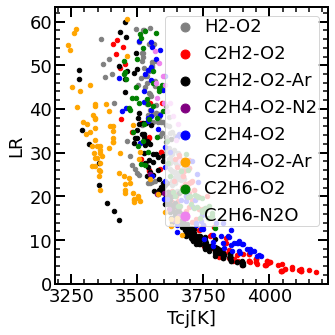

In [ ]:
#Index(['P0', 'H0[KJ/kg]', 'M0[kg/kmol]', 'γ0[-]', 'pcj[bar]', 'Tcj[K]',
#       'Hcj[KJ/kg]', 'Mcj[kg/kmol]', 'γcj[-]', 'Mcj[-]', 'Tvn[K]', 'theta'],
#      dtype='object')



plt.figure(figsize=(5,5))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5

plt.scatter(XH2trainval['Tcj[K]'],yH2trainval,s=20,color='grey',label='H2-O2')
plt.scatter(XC2H2trainval['Tcj[K]'],yC2H2trainval,s=20,color='red',label='C2H2-O2')
plt.scatter(XC2H2ARtrainval['Tcj[K]'],yC2H2ARtrainval,s=20,color='black',label='C2H2-O2-Ar')
plt.scatter(XC2H2N2trainval['Tcj[K]'],yC2H2N2trainval,s=20,color='purple',label='C2H4-O2-N2')
plt.scatter(XC2H4trainval['Tcj[K]'],yC2H4trainval,s=20,color='blue',label='C2H4-O2')
plt.scatter(XC2H4ARtrainval['Tcj[K]'],yC2H4ARtrainval,s=20,color='orange',label='C2H4-O2-Ar')
plt.scatter(XC2H6trainval['Tcj[K]'],yC2H6trainval,s=20,color='green',label='C2H6-O2')
plt.scatter(XC2H6N2Otrainval['Tcj[K]'],yC2H6N2Otrainval,s=20,color='violet',label='C2H6-N2O')

#plt.xlim(3200, 4200)
#plt.ylim(0, 60)
#plt.xticks(np.arange(3200, 4201, step=500))
#plt.yticks(np.arange(0, 61, step=20))
plt.xlabel('Tcj[K]')
plt.ylabel('LR')
plt.tight_layout()
plt.legend(markerscale = 2,handletextpad=0.1,borderpad=0.1)
plt.savefig("gurafu29.png")

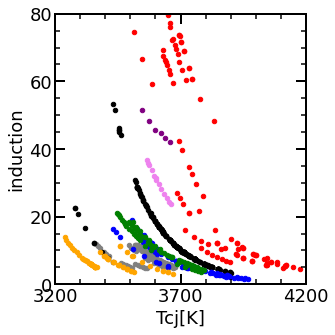

In [ ]:
#Index(['P0', 'H0[KJ/kg]', 'M0[kg/kmol]', 'γ0[-]', 'pcj[bar]', 'Tcj[K]',
#       'Hcj[KJ/kg]', 'Mcj[kg/kmol]', 'γcj[-]', 'Mcj[-]', 'Tvn[K]', 'theta'],
#      dtype='object')



plt.figure(figsize=(5,5))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5

plt.scatter(XH2trainval['Tcj[K]'],yH2induction,s=20,color='grey')
plt.scatter(XC2H2trainval['Tcj[K]'],yC2H2induction,s=20,color='red')
plt.scatter(XC2H2ARtrainval['Tcj[K]'],yC2H2ARinduction,s=20,color='black')
plt.scatter(XC2H2N2trainval['Tcj[K]'],yC2H2N2induction,s=20,color='purple')
plt.scatter(XC2H4trainval['Tcj[K]'],yC2H4induction,s=20,color='blue')
plt.scatter(XC2H4ARtrainval['Tcj[K]'],yC2H4ARinduction,s=20,color='orange')
plt.scatter(XC2H6trainval['Tcj[K]'],yC2H6induction,s=20,color='green')
plt.scatter(XC2H6N2Otrainval['Tcj[K]'],yC2H6N2Oinduction,s=20,color='violet')

plt.xlim(3200, 4200)
plt.ylim(0, 80)
plt.xticks(np.arange(3200, 4201, step=500))
plt.yticks(np.arange(0, 81, step=20))
plt.xlabel('Tcj[K]')
plt.ylabel('induction')
plt.tight_layout()
plt.savefig("gurafu29.png")

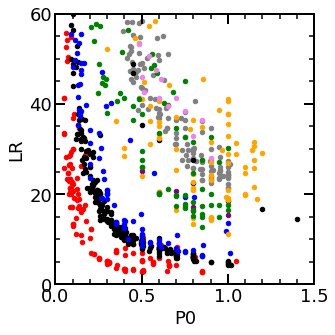

In [ ]:
#Index(['P0', 'H0[KJ/kg]', 'M0[kg/kmol]', 'γ0[-]', 'pcj[bar]', 'Tcj[K]',
#       'Hcj[KJ/kg]', 'Mcj[kg/kmol]', 'γcj[-]', 'Mcj[-]', 'Tvn[K]', 'theta'],
#      dtype='object')



plt.figure(figsize=(5,5))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5

plt.scatter(XH2trainval['P0'],yH2trainval,s=20,color='grey')
plt.scatter(XC2H2trainval['P0'],yC2H2trainval,s=20,color='red')
plt.scatter(XC2H2ARtrainval['P0'],yC2H2ARtrainval,s=20,color='black')
plt.scatter(XC2H2N2trainval['P0'],yC2H2N2trainval,s=20,color='purple')
plt.scatter(XC2H4trainval['P0'],yC2H4trainval,s=20,color='blue')
plt.scatter(XC2H4ARtrainval['P0'],yC2H4ARtrainval,s=20,color='orange')
plt.scatter(XC2H6trainval['P0'],yC2H6trainval,s=20,color='green')
plt.scatter(XC2H6N2Otrainval['P0'],yC2H6N2Otrainval,s=20,color='violet')

plt.xlim(0, 1.501)
plt.ylim(0, 60)
plt.xticks(np.arange(0, 1.501, step=0.5))
plt.yticks(np.arange(0, 61, step=20))
plt.xlabel('P0')
plt.ylabel('LR')
plt.tight_layout()
plt.savefig("gurafu29.png")

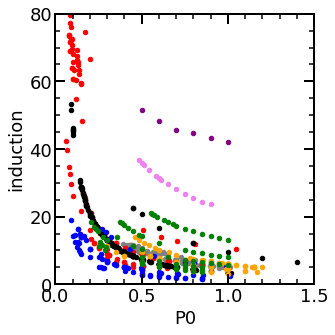

In [ ]:
#Index(['P0', 'H0[KJ/kg]', 'M0[kg/kmol]', 'γ0[-]', 'pcj[bar]', 'Tcj[K]',
#       'Hcj[KJ/kg]', 'Mcj[kg/kmol]', 'γcj[-]', 'Mcj[-]', 'Tvn[K]', 'theta'],
#      dtype='object')



plt.figure(figsize=(5,5))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5

plt.scatter(XH2trainval['P0'],yH2induction,s=20,color='grey')
plt.scatter(XC2H2trainval['P0'],yC2H2induction,s=20,color='red')
plt.scatter(XC2H2ARtrainval['P0'],yC2H2ARinduction,s=20,color='black')
plt.scatter(XC2H2N2trainval['P0'],yC2H2N2induction,s=20,color='purple')
plt.scatter(XC2H4trainval['P0'],yC2H4induction,s=20,color='blue')
plt.scatter(XC2H4ARtrainval['P0'],yC2H4ARinduction,s=20,color='orange')
plt.scatter(XC2H6trainval['P0'],yC2H6induction,s=20,color='green')
plt.scatter(XC2H6N2Otrainval['P0'],yC2H6N2Oinduction,s=20,color='violet')

plt.xlim(0, 1.501)
plt.ylim(0, 80)
plt.xticks(np.arange(0, 1.501, step=0.5))
plt.yticks(np.arange(0, 81, step=20))
plt.xlabel('P0')
plt.ylabel('induction')
plt.tight_layout()
plt.savefig("gurafu29.png")

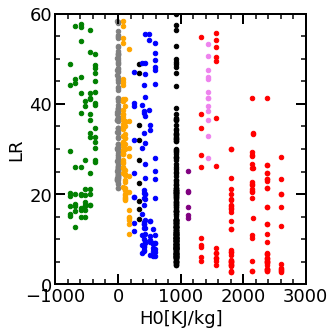

In [ ]:
#Index(['P0', 'H0[KJ/kg]', 'M0[kg/kmol]', 'γ0[-]', 'pcj[bar]', 'Tcj[K]',
#       'Hcj[KJ/kg]', 'Mcj[kg/kmol]', 'γcj[-]', 'Mcj[-]', 'Tvn[K]', 'theta'],
#      dtype='object')



plt.figure(figsize=(5,5))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5

plt.scatter(XH2trainval['H0[KJ/kg]'],yH2trainval,s=20,color='grey')
plt.scatter(XC2H2trainval['H0[KJ/kg]'],yC2H2trainval,s=20,color='red')
plt.scatter(XC2H2ARtrainval['H0[KJ/kg]'],yC2H2ARtrainval,s=20,color='black')
plt.scatter(XC2H2N2trainval['H0[KJ/kg]'],yC2H2N2trainval,s=20,color='purple')
plt.scatter(XC2H4trainval['H0[KJ/kg]'],yC2H4trainval,s=20,color='blue')
plt.scatter(XC2H4ARtrainval['H0[KJ/kg]'],yC2H4ARtrainval,s=20,color='orange')
plt.scatter(XC2H6trainval['H0[KJ/kg]'],yC2H6trainval,s=20,color='green')
plt.scatter(XC2H6N2Otrainval['H0[KJ/kg]'],yC2H6N2Otrainval,s=20,color='violet')

plt.xlim(-1000, 3000)
plt.ylim(0, 60)
plt.xticks(np.arange(-1000, 3001, step=1000))
plt.yticks(np.arange(0, 61, step=20))
plt.xlabel('H0[KJ/kg]')
plt.ylabel('LR')
plt.tight_layout()
plt.savefig("gurafu29.png")

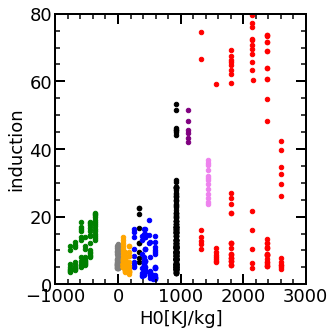

In [ ]:
#Index(['P0', 'H0[KJ/kg]', 'M0[kg/kmol]', 'γ0[-]', 'pcj[bar]', 'Tcj[K]',
#       'Hcj[KJ/kg]', 'Mcj[kg/kmol]', 'γcj[-]', 'Mcj[-]', 'Tvn[K]', 'theta'],
#      dtype='object')



plt.figure(figsize=(5,5))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5

plt.scatter(XH2trainval['H0[KJ/kg]'],yH2induction,s=20,color='grey')
plt.scatter(XC2H2trainval['H0[KJ/kg]'],yC2H2induction,s=20,color='red')
plt.scatter(XC2H2ARtrainval['H0[KJ/kg]'],yC2H2ARinduction,s=20,color='black')
plt.scatter(XC2H2N2trainval['H0[KJ/kg]'],yC2H2N2induction,s=20,color='purple')
plt.scatter(XC2H4trainval['H0[KJ/kg]'],yC2H4induction,s=20,color='blue')
plt.scatter(XC2H4ARtrainval['H0[KJ/kg]'],yC2H4ARinduction,s=20,color='orange')
plt.scatter(XC2H6trainval['H0[KJ/kg]'],yC2H6induction,s=20,color='green')
plt.scatter(XC2H6N2Otrainval['H0[KJ/kg]'],yC2H6N2Oinduction,s=20,color='violet')

plt.xlim(-1000, 3000)
plt.ylim(0, 80)
plt.xticks(np.arange(-1000, 3001, step=1000))
plt.yticks(np.arange(0, 81, step=20))
plt.xlabel('H0[KJ/kg]')
plt.ylabel('induction')
plt.tight_layout()
plt.savefig("gurafu29.png")

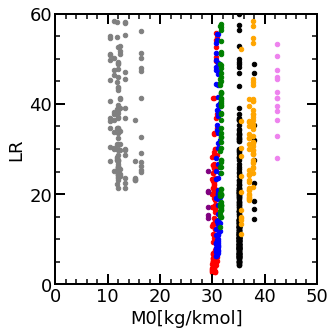

In [ ]:
#Index(['P0', 'H0[KJ/kg]', 'M0[kg/kmol]', 'γ0[-]', 'pcj[bar]', 'Tcj[K]',
#       'Hcj[KJ/kg]', 'Mcj[kg/kmol]', 'γcj[-]', 'Mcj[-]', 'Tvn[K]', 'theta'],
#      dtype='object')



plt.figure(figsize=(5,5))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5

plt.scatter(XH2trainval['M0[kg/kmol]'],yH2trainval,s=20,color='grey')
plt.scatter(XC2H2trainval['M0[kg/kmol]'],yC2H2trainval,s=20,color='red')
plt.scatter(XC2H2ARtrainval['M0[kg/kmol]'],yC2H2ARtrainval,s=20,color='black')
plt.scatter(XC2H2N2trainval['M0[kg/kmol]'],yC2H2N2trainval,s=20,color='purple')
plt.scatter(XC2H4trainval['M0[kg/kmol]'],yC2H4trainval,s=20,color='blue')
plt.scatter(XC2H4ARtrainval['M0[kg/kmol]'],yC2H4ARtrainval,s=20,color='orange')
plt.scatter(XC2H6trainval['M0[kg/kmol]'],yC2H6trainval,s=20,color='green')
plt.scatter(XC2H6N2Otrainval['M0[kg/kmol]'],yC2H6N2Otrainval,s=20,color='violet')

plt.xlim(0, 50)
plt.ylim(0, 60)
plt.xticks(np.arange(0, 51, step=10))
plt.yticks(np.arange(0, 61, step=20))
plt.xlabel('M0[kg/kmol]')
plt.ylabel('LR')
plt.tight_layout()
plt.savefig("gurafu29.png")

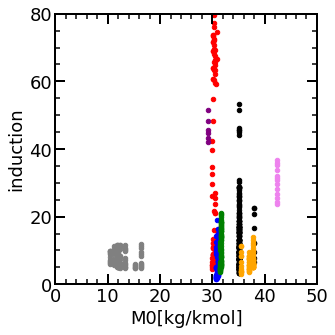

In [ ]:
#Index(['P0', 'H0[KJ/kg]', 'M0[kg/kmol]', 'γ0[-]', 'pcj[bar]', 'Tcj[K]',
#       'Hcj[KJ/kg]', 'Mcj[kg/kmol]', 'γcj[-]', 'Mcj[-]', 'Tvn[K]', 'theta'],
#      dtype='object')



plt.figure(figsize=(5,5))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5

plt.scatter(XH2trainval['M0[kg/kmol]'],yH2induction,s=20,color='grey')
plt.scatter(XC2H2trainval['M0[kg/kmol]'],yC2H2induction,s=20,color='red')
plt.scatter(XC2H2ARtrainval['M0[kg/kmol]'],yC2H2ARinduction,s=20,color='black')
plt.scatter(XC2H2N2trainval['M0[kg/kmol]'],yC2H2N2induction,s=20,color='purple')
plt.scatter(XC2H4trainval['M0[kg/kmol]'],yC2H4induction,s=20,color='blue')
plt.scatter(XC2H4ARtrainval['M0[kg/kmol]'],yC2H4ARinduction,s=20,color='orange')
plt.scatter(XC2H6trainval['M0[kg/kmol]'],yC2H6induction,s=20,color='green')
plt.scatter(XC2H6N2Otrainval['M0[kg/kmol]'],yC2H6N2Oinduction,s=20,color='violet')

plt.xlim(0, 50)
plt.ylim(0, 80)
plt.xticks(np.arange(0, 51, step=10))
plt.yticks(np.arange(0, 81, step=20))
plt.xlabel('M0[kg/kmol]')
plt.ylabel('induction')
plt.tight_layout()
plt.savefig("gurafu29.png")

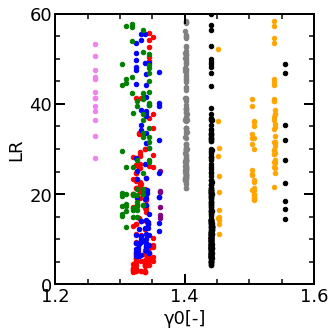

In [ ]:
#Index(['P0', 'H0[KJ/kg]', 'M0[kg/kmol]', 'γ0[-]', 'pcj[bar]', 'Tcj[K]',
#       'Hcj[KJ/kg]', 'Mcj[kg/kmol]', 'γcj[-]', 'Mcj[-]', 'Tvn[K]', 'theta'],
#      dtype='object')



plt.figure(figsize=(5,5))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5

plt.scatter(XH2trainval['γ0[-]'],yH2trainval,s=20,color='grey')
plt.scatter(XC2H2trainval['γ0[-]'],yC2H2trainval,s=20,color='red')
plt.scatter(XC2H2ARtrainval['γ0[-]'],yC2H2ARtrainval,s=20,color='black')
plt.scatter(XC2H2N2trainval['γ0[-]'],yC2H2N2trainval,s=20,color='purple')
plt.scatter(XC2H4trainval['γ0[-]'],yC2H4trainval,s=20,color='blue')
plt.scatter(XC2H4ARtrainval['γ0[-]'],yC2H4ARtrainval,s=20,color='orange')
plt.scatter(XC2H6trainval['γ0[-]'],yC2H6trainval,s=20,color='green')
plt.scatter(XC2H6N2Otrainval['γ0[-]'],yC2H6N2Otrainval,s=20,color='violet')

plt.xlim(1.2, 1.6)
plt.ylim(0, 60)
plt.xticks(np.arange(1.2, 1.61, step=0.2))
plt.yticks(np.arange(0, 61, step=20))
plt.xlabel('γ0[-]')
plt.ylabel('LR')
plt.tight_layout()
plt.savefig("gurafu29.png")

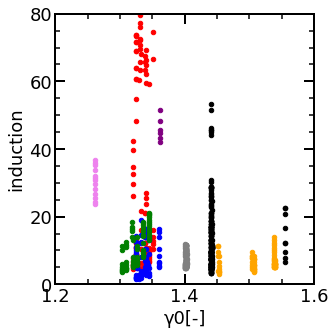

In [ ]:
#Index(['P0', 'H0[KJ/kg]', 'M0[kg/kmol]', 'γ0[-]', 'pcj[bar]', 'Tcj[K]',
#       'Hcj[KJ/kg]', 'Mcj[kg/kmol]', 'γcj[-]', 'Mcj[-]', 'Tvn[K]', 'theta'],
#      dtype='object')



plt.figure(figsize=(5,5))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5

plt.scatter(XH2trainval['γ0[-]'],yH2induction,s=20,color='grey')
plt.scatter(XC2H2trainval['γ0[-]'],yC2H2induction,s=20,color='red')
plt.scatter(XC2H2ARtrainval['γ0[-]'],yC2H2ARinduction,s=20,color='black')
plt.scatter(XC2H2N2trainval['γ0[-]'],yC2H2N2induction,s=20,color='purple')
plt.scatter(XC2H4trainval['γ0[-]'],yC2H4induction,s=20,color='blue')
plt.scatter(XC2H4ARtrainval['γ0[-]'],yC2H4ARinduction,s=20,color='orange')
plt.scatter(XC2H6trainval['γ0[-]'],yC2H6induction,s=20,color='green')
plt.scatter(XC2H6N2Otrainval['γ0[-]'],yC2H6N2Oinduction,s=20,color='violet')

plt.xlim(1.2, 1.6)
plt.ylim(0, 80)
plt.xticks(np.arange(1.2, 1.61, step=0.2))
plt.yticks(np.arange(0, 81, step=20))
plt.xlabel('γ0[-]')
plt.ylabel('induction')
plt.tight_layout()
plt.savefig("gurafu29.png")

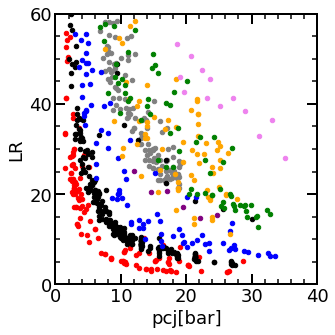

In [ ]:
#Index(['P0', 'H0[KJ/kg]', 'M0[kg/kmol]', 'γ0[-]', 'pcj[bar]', 'Tcj[K]',
#       'Hcj[KJ/kg]', 'Mcj[kg/kmol]', 'γcj[-]', 'Mcj[-]', 'Tvn[K]', 'theta'],
#      dtype='object')

plt.figure(figsize=(5,5))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5

plt.scatter(XH2trainval['pcj[bar]'],yH2trainval,s=20,color='grey')
plt.scatter(XC2H2trainval['pcj[bar]'],yC2H2trainval,s=20,color='red')
plt.scatter(XC2H2ARtrainval['pcj[bar]'],yC2H2ARtrainval,s=20,color='black')
plt.scatter(XC2H2N2trainval['pcj[bar]'],yC2H2N2trainval,s=20,color='purple')
plt.scatter(XC2H4trainval['pcj[bar]'],yC2H4trainval,s=20,color='blue')
plt.scatter(XC2H4ARtrainval['pcj[bar]'],yC2H4ARtrainval,s=20,color='orange')
plt.scatter(XC2H6trainval['pcj[bar]'],yC2H6trainval,s=20,color='green')
plt.scatter(XC2H6N2Otrainval['pcj[bar]'],yC2H6N2Otrainval,s=20,color='violet')

plt.xlim(0, 40)
plt.ylim(0, 60)
plt.xticks(np.arange(0, 41, step=10))
plt.yticks(np.arange(0, 61, step=20))
plt.xlabel('pcj[bar]')
plt.ylabel('LR')
plt.tight_layout()
plt.savefig("gurafu29.png")

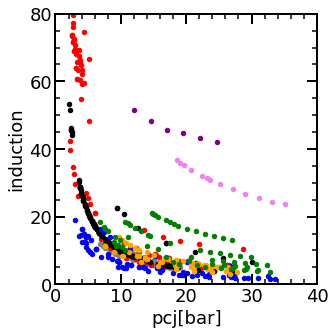

In [ ]:
#Index(['P0', 'H0[KJ/kg]', 'M0[kg/kmol]', 'γ0[-]', 'pcj[bar]', 'Tcj[K]',
#       'Hcj[KJ/kg]', 'Mcj[kg/kmol]', 'γcj[-]', 'Mcj[-]', 'Tvn[K]', 'theta'],
#      dtype='object')



plt.figure(figsize=(5,5))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5

plt.scatter(XH2trainval['pcj[bar]'],yH2induction,s=20,color='grey')
plt.scatter(XC2H2trainval['pcj[bar]'],yC2H2induction,s=20,color='red')
plt.scatter(XC2H2ARtrainval['pcj[bar]'],yC2H2ARinduction,s=20,color='black')
plt.scatter(XC2H2N2trainval['pcj[bar]'],yC2H2N2induction,s=20,color='purple')
plt.scatter(XC2H4trainval['pcj[bar]'],yC2H4induction,s=20,color='blue')
plt.scatter(XC2H4ARtrainval['pcj[bar]'],yC2H4ARinduction,s=20,color='orange')
plt.scatter(XC2H6trainval['pcj[bar]'],yC2H6induction,s=20,color='green')
plt.scatter(XC2H6N2Otrainval['pcj[bar]'],yC2H6N2Oinduction,s=20,color='violet')

plt.xlim(0, 40)
plt.ylim(0, 80)
plt.xticks(np.arange(0, 41, step=10))
plt.yticks(np.arange(0, 81, step=20))
plt.xlabel('pcj[bar]')
plt.ylabel('induction')
plt.tight_layout()
plt.savefig("gurafu29.png")

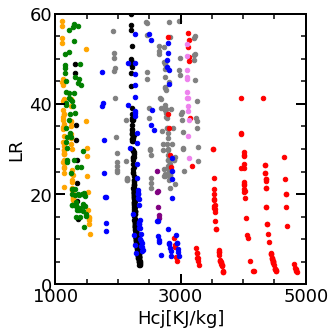

In [ ]:
#Index(['P0', 'H0[KJ/kg]', 'M0[kg/kmol]', 'γ0[-]', 'pcj[bar]', 'Tcj[K]',
#       'Hcj[KJ/kg]', 'Mcj[kg/kmol]', 'γcj[-]', 'Mcj[-]', 'Tvn[K]', 'theta'],
#      dtype='object')

plt.figure(figsize=(5,5))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5

plt.scatter(XH2trainval['Hcj[KJ/kg]'],yH2trainval,s=20,color='grey')
plt.scatter(XC2H2trainval['Hcj[KJ/kg]'],yC2H2trainval,s=20,color='red')
plt.scatter(XC2H2ARtrainval['Hcj[KJ/kg]'],yC2H2ARtrainval,s=20,color='black')
plt.scatter(XC2H2N2trainval['Hcj[KJ/kg]'],yC2H2N2trainval,s=20,color='purple')
plt.scatter(XC2H4trainval['Hcj[KJ/kg]'],yC2H4trainval,s=20,color='blue')
plt.scatter(XC2H4ARtrainval['Hcj[KJ/kg]'],yC2H4ARtrainval,s=20,color='orange')
plt.scatter(XC2H6trainval['Hcj[KJ/kg]'],yC2H6trainval,s=20,color='green')
plt.scatter(XC2H6N2Otrainval['Hcj[KJ/kg]'],yC2H6N2Otrainval,s=20,color='violet')

plt.xlim(1000, 5000)
plt.ylim(0, 60)
plt.xticks(np.arange(1000, 5001, step=2000))
plt.yticks(np.arange(0, 61, step=20))
plt.xlabel('Hcj[KJ/kg]')
plt.ylabel('LR')
plt.tight_layout()
plt.savefig("gurafu29.png")

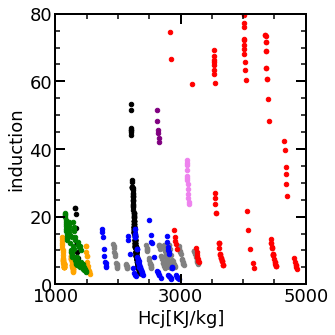

In [ ]:
#Index(['P0', 'H0[KJ/kg]', 'M0[kg/kmol]', 'γ0[-]', 'pcj[bar]', 'Tcj[K]',
#       'Hcj[KJ/kg]', 'Mcj[kg/kmol]', 'γcj[-]', 'Mcj[-]', 'Tvn[K]', 'theta'],
#      dtype='object')



plt.figure(figsize=(5,5))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5

plt.scatter(XH2trainval['Hcj[KJ/kg]'],yH2induction,s=20,color='grey')
plt.scatter(XC2H2trainval['Hcj[KJ/kg]'],yC2H2induction,s=20,color='red')
plt.scatter(XC2H2ARtrainval['Hcj[KJ/kg]'],yC2H2ARinduction,s=20,color='black')
plt.scatter(XC2H2N2trainval['Hcj[KJ/kg]'],yC2H2N2induction,s=20,color='purple')
plt.scatter(XC2H4trainval['Hcj[KJ/kg]'],yC2H4induction,s=20,color='blue')
plt.scatter(XC2H4ARtrainval['Hcj[KJ/kg]'],yC2H4ARinduction,s=20,color='orange')
plt.scatter(XC2H6trainval['Hcj[KJ/kg]'],yC2H6induction,s=20,color='green')
plt.scatter(XC2H6N2Otrainval['Hcj[KJ/kg]'],yC2H6N2Oinduction,s=20,color='violet')

plt.xlim(1000, 5000)
plt.ylim(0, 80)
plt.xticks(np.arange(1000, 5001, step=2000))
plt.yticks(np.arange(0, 81, step=20))
plt.xlabel('Hcj[KJ/kg]')
plt.ylabel('induction')
plt.tight_layout()
plt.savefig("gurafu29.png")

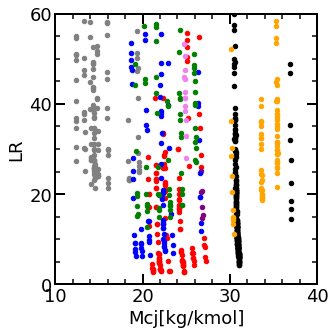

In [ ]:
#Index(['P0', 'H0[KJ/kg]', 'M0[kg/kmol]', 'γ0[-]', 'pcj[bar]', 'Tcj[K]',
#       'Hcj[KJ/kg]', 'Mcj[kg/kmol]', 'γcj[-]', 'Mcj[-]', 'Tvn[K]', 'theta'],
#      dtype='object')

plt.figure(figsize=(5,5))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5

plt.scatter(XH2trainval['Mcj[kg/kmol]'],yH2trainval,s=20,color='grey')
plt.scatter(XC2H2trainval['Mcj[kg/kmol]'],yC2H2trainval,s=20,color='red')
plt.scatter(XC2H2ARtrainval['Mcj[kg/kmol]'],yC2H2ARtrainval,s=20,color='black')
plt.scatter(XC2H2N2trainval['Mcj[kg/kmol]'],yC2H2N2trainval,s=20,color='purple')
plt.scatter(XC2H4trainval['Mcj[kg/kmol]'],yC2H4trainval,s=20,color='blue')
plt.scatter(XC2H4ARtrainval['Mcj[kg/kmol]'],yC2H4ARtrainval,s=20,color='orange')
plt.scatter(XC2H6trainval['Mcj[kg/kmol]'],yC2H6trainval,s=20,color='green')
plt.scatter(XC2H6N2Otrainval['Mcj[kg/kmol]'],yC2H6N2Otrainval,s=20,color='violet')

plt.xlim(10, 40)
plt.ylim(0, 60)
plt.xticks(np.arange(10, 41, step=10))
plt.yticks(np.arange(0, 61, step=20))
plt.xlabel('Mcj[kg/kmol]')
plt.ylabel('LR')
plt.tight_layout()
plt.savefig("gurafu29.png")

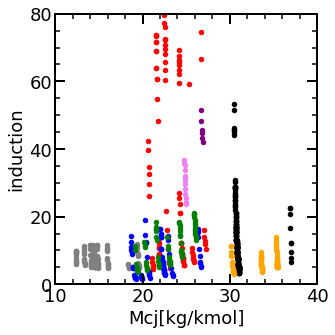

In [ ]:
#Index(['P0', 'H0[KJ/kg]', 'M0[kg/kmol]', 'γ0[-]', 'pcj[bar]', 'Tcj[K]',
#       'Hcj[KJ/kg]', 'Mcj[kg/kmol]', 'γcj[-]', 'Mcj[-]', 'Tvn[K]', 'theta'],
#      dtype='object')



plt.figure(figsize=(5,5))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5

plt.scatter(XH2trainval['Mcj[kg/kmol]'],yH2induction,s=20,color='grey')
plt.scatter(XC2H2trainval['Mcj[kg/kmol]'],yC2H2induction,s=20,color='red')
plt.scatter(XC2H2ARtrainval['Mcj[kg/kmol]'],yC2H2ARinduction,s=20,color='black')
plt.scatter(XC2H2N2trainval['Mcj[kg/kmol]'],yC2H2N2induction,s=20,color='purple')
plt.scatter(XC2H4trainval['Mcj[kg/kmol]'],yC2H4induction,s=20,color='blue')
plt.scatter(XC2H4ARtrainval['Mcj[kg/kmol]'],yC2H4ARinduction,s=20,color='orange')
plt.scatter(XC2H6trainval['Mcj[kg/kmol]'],yC2H6induction,s=20,color='green')
plt.scatter(XC2H6N2Otrainval['Mcj[kg/kmol]'],yC2H6N2Oinduction,s=20,color='violet')

plt.xlim(10, 40)
plt.ylim(0, 80)
plt.xticks(np.arange(10, 41, step=10))
plt.yticks(np.arange(0, 81, step=20))
plt.xlabel('Mcj[kg/kmol]')
plt.ylabel('induction')
plt.tight_layout()
plt.savefig("gurafu29.png")

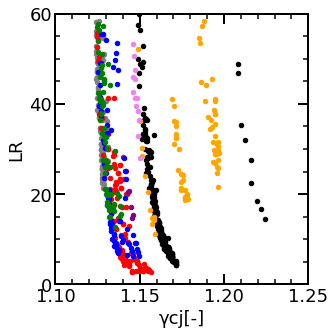

In [ ]:
#Index(['P0', 'H0[KJ/kg]', 'M0[kg/kmol]', 'γ0[-]', 'pcj[bar]', 'Tcj[K]',
#       'Hcj[KJ/kg]', 'Mcj[kg/kmol]', 'γcj[-]', 'Mcj[-]', 'Tvn[K]', 'theta'],
#      dtype='object')

plt.figure(figsize=(5,5))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5

plt.scatter(XH2trainval['γcj[-]'],yH2trainval,s=20,color='grey')
plt.scatter(XC2H2trainval['γcj[-]'],yC2H2trainval,s=20,color='red')
plt.scatter(XC2H2ARtrainval['γcj[-]'],yC2H2ARtrainval,s=20,color='black')
plt.scatter(XC2H2N2trainval['γcj[-]'],yC2H2N2trainval,s=20,color='purple')
plt.scatter(XC2H4trainval['γcj[-]'],yC2H4trainval,s=20,color='blue')
plt.scatter(XC2H4ARtrainval['γcj[-]'],yC2H4ARtrainval,s=20,color='orange')
plt.scatter(XC2H6trainval['γcj[-]'],yC2H6trainval,s=20,color='green')
plt.scatter(XC2H6N2Otrainval['γcj[-]'],yC2H6N2Otrainval,s=20,color='violet')

plt.xlim(1.1, 1.25)
plt.ylim(0, 60)
plt.xticks(np.arange(1.1, 1.251, step=0.05))
plt.yticks(np.arange(0, 61, step=20))
plt.xlabel('γcj[-]')
plt.ylabel('LR')
plt.tight_layout()
plt.savefig("gurafu29.png")

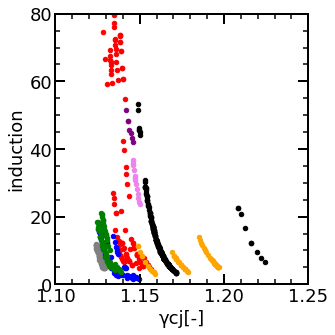

In [ ]:
#Index(['P0', 'H0[KJ/kg]', 'M0[kg/kmol]', 'γ0[-]', 'pcj[bar]', 'Tcj[K]',
#       'Hcj[KJ/kg]', 'Mcj[kg/kmol]', 'γcj[-]', 'Mcj[-]', 'Tvn[K]', 'theta'],
#      dtype='object')



plt.figure(figsize=(5,5))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5

plt.scatter(XH2trainval['γcj[-]'],yH2induction,s=20,color='grey')
plt.scatter(XC2H2trainval['γcj[-]'],yC2H2induction,s=20,color='red')
plt.scatter(XC2H2ARtrainval['γcj[-]'],yC2H2ARinduction,s=20,color='black')
plt.scatter(XC2H2N2trainval['γcj[-]'],yC2H2N2induction,s=20,color='purple')
plt.scatter(XC2H4trainval['γcj[-]'],yC2H4induction,s=20,color='blue')
plt.scatter(XC2H4ARtrainval['γcj[-]'],yC2H4ARinduction,s=20,color='orange')
plt.scatter(XC2H6trainval['γcj[-]'],yC2H6induction,s=20,color='green')
plt.scatter(XC2H6N2Otrainval['γcj[-]'],yC2H6N2Oinduction,s=20,color='violet')

plt.xlim(1.1, 1.25)
plt.ylim(0, 80)
plt.xticks(np.arange(1.1, 1.251, step=0.05))
plt.yticks(np.arange(0, 81, step=20))
plt.xlabel('γcj[-]')
plt.ylabel('induction')
plt.tight_layout()
plt.savefig("gurafu29.png")

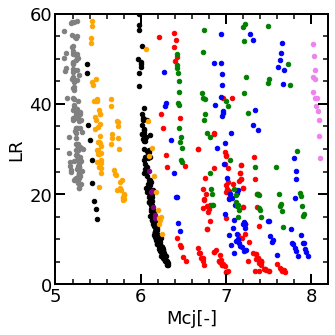

In [ ]:
#Index(['P0', 'H0[KJ/kg]', 'M0[kg/kmol]', 'γ0[-]', 'pcj[bar]', 'Tcj[K]',
#       'Hcj[KJ/kg]', 'Mcj[kg/kmol]', 'γcj[-]', 'Mcj[-]', 'Tvn[K]', 'theta'],
#      dtype='object')

plt.figure(figsize=(5,5))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5

plt.scatter(XH2trainval['Mcj[-]'],yH2trainval,s=20,color='grey')
plt.scatter(XC2H2trainval['Mcj[-]'],yC2H2trainval,s=20,color='red')
plt.scatter(XC2H2ARtrainval['Mcj[-]'],yC2H2ARtrainval,s=20,color='black')
plt.scatter(XC2H2N2trainval['Mcj[-]'],yC2H2N2trainval,s=20,color='purple')
plt.scatter(XC2H4trainval['Mcj[-]'],yC2H4trainval,s=20,color='blue')
plt.scatter(XC2H4ARtrainval['Mcj[-]'],yC2H4ARtrainval,s=20,color='orange')
plt.scatter(XC2H6trainval['Mcj[-]'],yC2H6trainval,s=20,color='green')
plt.scatter(XC2H6N2Otrainval['Mcj[-]'],yC2H6N2Otrainval,s=20,color='violet')

plt.xlim(5, 8.2)
plt.ylim(0, 60)
plt.xticks(np.arange(5, 8.2, step=1))
plt.yticks(np.arange(0, 61, step=20))
plt.xlabel('Mcj[-]')
plt.ylabel('LR')
plt.tight_layout()
plt.savefig("gurafu29.png")

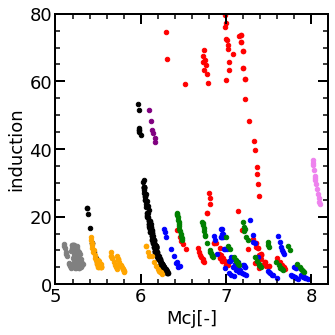

In [ ]:
#Index(['P0', 'H0[KJ/kg]', 'M0[kg/kmol]', 'γ0[-]', 'pcj[bar]', 'Tcj[K]',
#       'Hcj[KJ/kg]', 'Mcj[kg/kmol]', 'γcj[-]', 'Mcj[-]', 'Tvn[K]', 'theta'],
#      dtype='object')

plt.figure(figsize=(5,5))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5

plt.scatter(XH2trainval['Mcj[-]'],yH2induction,s=20,color='grey')
plt.scatter(XC2H2trainval['Mcj[-]'],yC2H2induction,s=20,color='red')
plt.scatter(XC2H2ARtrainval['Mcj[-]'],yC2H2ARinduction,s=20,color='black')
plt.scatter(XC2H2N2trainval['Mcj[-]'],yC2H2N2induction,s=20,color='purple')
plt.scatter(XC2H4trainval['Mcj[-]'],yC2H4induction,s=20,color='blue')
plt.scatter(XC2H4ARtrainval['Mcj[-]'],yC2H4ARinduction,s=20,color='orange')
plt.scatter(XC2H6trainval['Mcj[-]'],yC2H6induction,s=20,color='green')
plt.scatter(XC2H6N2Otrainval['Mcj[-]'],yC2H6N2Oinduction,s=20,color='violet')

plt.xlim(5, 8.2)
plt.ylim(0, 80)
plt.xticks(np.arange(5, 8.2, step=1))
plt.yticks(np.arange(0, 81, step=20))
plt.xlabel('Mcj[-]')
plt.ylabel('induction')
plt.tight_layout()
plt.savefig("gurafu29.png")

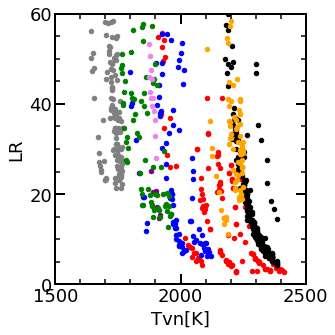

In [ ]:
#Index(['P0', 'H0[KJ/kg]', 'M0[kg/kmol]', 'γ0[-]', 'pcj[bar]', 'Tcj[K]',
#       'Hcj[KJ/kg]', 'Mcj[kg/kmol]', 'γcj[-]', 'Mcj[-]', 'Tvn[K]', 'theta'],
#      dtype='object')

plt.figure(figsize=(5,5))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5

plt.scatter(XH2trainval['Tvn[K]'],yH2trainval,s=20,color='grey')
plt.scatter(XC2H2trainval['Tvn[K]'],yC2H2trainval,s=20,color='red')
plt.scatter(XC2H2ARtrainval['Tvn[K]'],yC2H2ARtrainval,s=20,color='black')
plt.scatter(XC2H2N2trainval['Tvn[K]'],yC2H2N2trainval,s=20,color='purple')
plt.scatter(XC2H4trainval['Tvn[K]'],yC2H4trainval,s=20,color='blue')
plt.scatter(XC2H4ARtrainval['Tvn[K]'],yC2H4ARtrainval,s=20,color='orange')
plt.scatter(XC2H6trainval['Tvn[K]'],yC2H6trainval,s=20,color='green')
plt.scatter(XC2H6N2Otrainval['Tvn[K]'],yC2H6N2Otrainval,s=20,color='violet')

plt.xlim(1500, 2500)
plt.ylim(0, 60)
plt.xticks(np.arange(1500, 2501, step=500))
plt.yticks(np.arange(0, 61, step=20))
plt.xlabel('Tvn[K]')
plt.ylabel('LR')
plt.tight_layout()
plt.savefig("gurafu29.png")

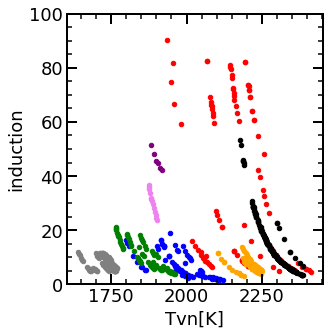

In [ ]:
#Index(['P0', 'H0[KJ/kg]', 'M0[kg/kmol]', 'γ0[-]', 'pcj[bar]', 'Tcj[K]',
#       'Hcj[KJ/kg]', 'Mcj[kg/kmol]', 'γcj[-]', 'Mcj[-]', 'Tvn[K]', 'theta'],
#      dtype='object')

plt.figure(figsize=(5,5))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5

plt.scatter(XH2trainval['Tvn[K]'],yH2induction,s=20,color='grey')
plt.scatter(XC2H2trainval['Tvn[K]'],yC2H2induction,s=20,color='red')
plt.scatter(XC2H2ARtrainval['Tvn[K]'],yC2H2ARinduction,s=20,color='black')
plt.scatter(XC2H2N2trainval['Tvn[K]'],yC2H2N2induction,s=20,color='purple')
plt.scatter(XC2H4trainval['Tvn[K]'],yC2H4induction,s=20,color='blue')
plt.scatter(XC2H4ARtrainval['Tvn[K]'],yC2H4ARinduction,s=20,color='orange')
plt.scatter(XC2H6trainval['Tvn[K]'],yC2H6induction,s=20,color='green')
plt.scatter(XC2H6N2Otrainval['Tvn[K]'],yC2H6N2Oinduction,s=20,color='violet')

#plt.xlim(0, 100)
plt.ylim(0, 100)
#plt.xticks(np.arange(3200, 4001, step=400))
#plt.yticks(np.arange(0, 61, step=20))
plt.xlabel('Tvn[K]')
plt.ylabel('induction')
plt.tight_layout()
plt.savefig("gurafu29.png")

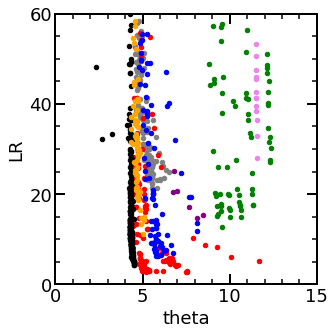

In [ ]:
#Index(['P0', 'H0[KJ/kg]', 'M0[kg/kmol]', 'γ0[-]', 'pcj[bar]', 'Tcj[K]',
#       'Hcj[KJ/kg]', 'Mcj[kg/kmol]', 'γcj[-]', 'Mcj[-]', 'Tvn[K]', 'theta'],
#      dtype='object')

plt.figure(figsize=(5,5))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5

plt.scatter(XH2trainval['theta'],yH2trainval,s=20,color='grey')
plt.scatter(XC2H2trainval['theta'],yC2H2trainval,s=20,color='red')
plt.scatter(XC2H2ARtrainval['theta'],yC2H2ARtrainval,s=20,color='black')
plt.scatter(XC2H2N2trainval['theta'],yC2H2N2trainval,s=20,color='purple')
plt.scatter(XC2H4trainval['theta'],yC2H4trainval,s=20,color='blue')
plt.scatter(XC2H4ARtrainval['theta'],yC2H4ARtrainval,s=20,color='orange')
plt.scatter(XC2H6trainval['theta'],yC2H6trainval,s=20,color='green')
plt.scatter(XC2H6N2Otrainval['theta'],yC2H6N2Otrainval,s=20,color='violet')

plt.xlim(0, 15)
plt.ylim(0, 60)
plt.xticks(np.arange(0, 15.1, step=5))
plt.yticks(np.arange(0, 61, step=20))
plt.xlabel('theta')
plt.ylabel('LR')
plt.tight_layout()
plt.savefig("gurafu29.png")

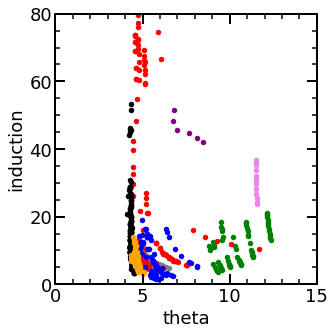

In [ ]:
#Index(['P0', 'H0[KJ/kg]', 'M0[kg/kmol]', 'γ0[-]', 'pcj[bar]', 'Tcj[K]',
#       'Hcj[KJ/kg]', 'Mcj[kg/kmol]', 'γcj[-]', 'Mcj[-]', 'Tvn[K]', 'theta'],
#      dtype='object')

plt.figure(figsize=(5,5))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5

plt.scatter(XH2trainval['theta'],yH2induction,s=20,color='grey')
plt.scatter(XC2H2trainval['theta'],yC2H2induction,s=20,color='red')
plt.scatter(XC2H2ARtrainval['theta'],yC2H2ARinduction,s=20,color='black')
plt.scatter(XC2H2N2trainval['theta'],yC2H2N2induction,s=20,color='purple')
plt.scatter(XC2H4trainval['theta'],yC2H4induction,s=20,color='blue')
plt.scatter(XC2H4ARtrainval['theta'],yC2H4ARinduction,s=20,color='orange')
plt.scatter(XC2H6trainval['theta'],yC2H6induction,s=20,color='green')
plt.scatter(XC2H6N2Otrainval['theta'],yC2H6N2Oinduction,s=20,color='violet')

plt.xlim(0, 15)
plt.ylim(0, 80)
plt.xticks(np.arange(0, 15.1, step=5))
plt.yticks(np.arange(0, 81, step=20))
plt.xlabel('theta')
plt.ylabel('induction')
plt.tight_layout()
plt.savefig("gurafu29.png")